In [1]:
%load_ext autoreload
%autoreload 2

import jax
from jax import numpy as jnp
from jax import random, lax
import flax
from flax.training import checkpoints
import optax
import distrax
import tensorflow as tf
import tensorflow_datasets as tfds
from clu import preprocess_spec, parameter_overview
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from NeurReps import preprocess_utils
from src.utils.training import TrainState
from src.utils.plotting import plot_img_array

In [2]:
BATCH_SIZE = 256
BATCH_SIZE_VAL = 100
PLOT_NUM_EXAMPLES = 16
LOW_ANGLE = -45
HIGH_ANGLE = 45
seed = 42

In [3]:
rng = random.PRNGKey(seed)

### Get Data

In [4]:
rng, shuffle_rng, pp_rng = random.split(rng, num=3)

In [5]:
pp_train = f'value_range(-1, 1)|random_rotate({LOW_ANGLE}, {HIGH_ANGLE}, fill_value=-1)|keep(["image"])'

def make_pp_with_rng(pp_str):
    preprocess_fn = preprocess_spec.parse(
          spec=pp_train, available_ops=preprocess_utils.all_ops())

    def preprocess_with_rng(example_index, features):
        example_index = tf.cast(example_index, tf.int32)
        features["rng"] = tf.random.experimental.stateless_fold_in(
            tf.cast(pp_rng, tf.int64), example_index)
        processed = preprocess_fn(features)
        # del processed["rng"]
        return processed

    return preprocess_with_rng

train_pp_fn = make_pp_with_rng(pp_train)

In [6]:
train_ds = tfds.load('MNIST', split='train[10000:]')
train_ds = train_ds.shuffle(50_000, seed=shuffle_rng[0])
# NOTE: ordering of PP and repeat is important! 
# PP first -> same seed each time we see same example.
# PP last -> diff seed each time we see same example. Effectively more data.
train_ds = train_ds.enumerate().map(train_pp_fn, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.repeat()
train_ds = train_ds.batch(batch_size=BATCH_SIZE)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
train_ds = train_ds.as_numpy_iterator()

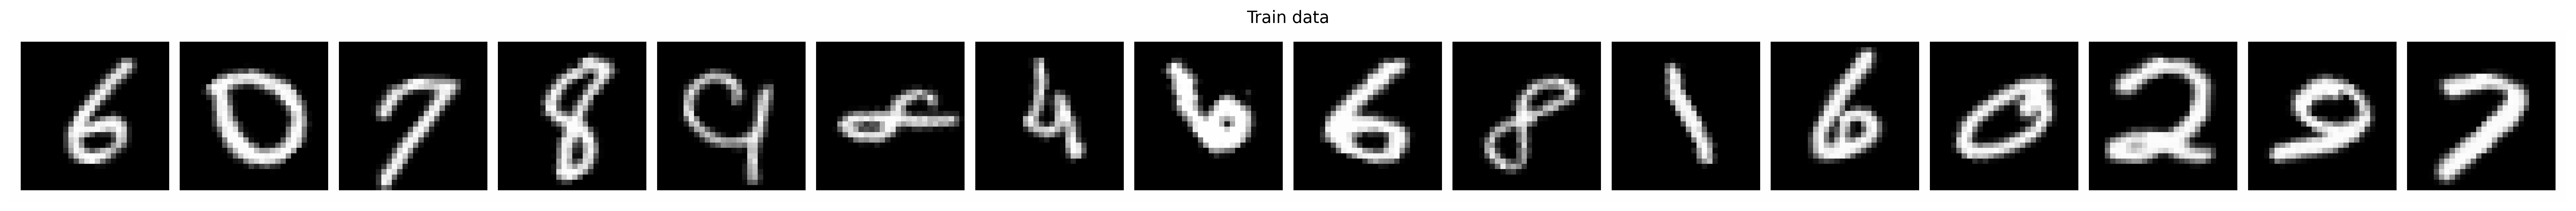

In [7]:
plot_img_array(next(train_ds)['image'][:PLOT_NUM_EXAMPLES], ncol=PLOT_NUM_EXAMPLES, title='Train data', pad_value=1);

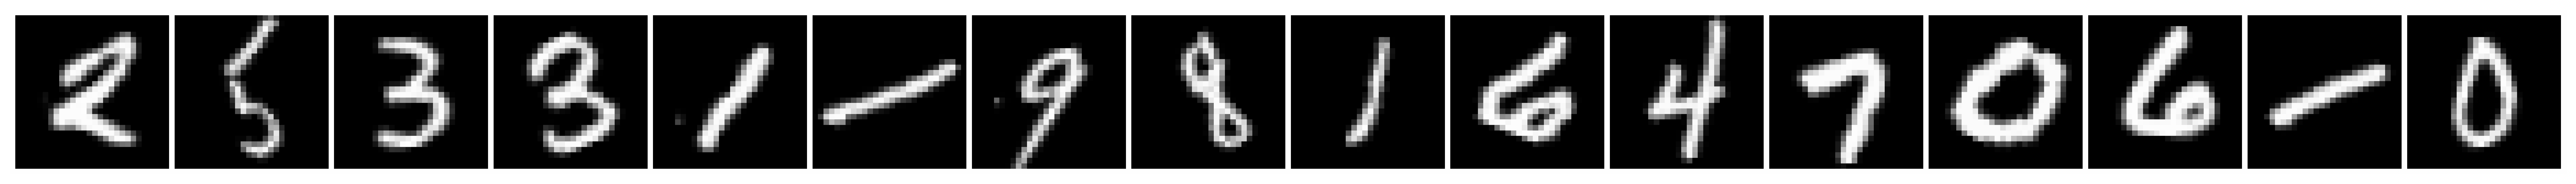

In [8]:
val_pp_fn = make_pp_with_rng(pp_train)

val_ds = tfds.load('MNIST', split='train[:10000]')
val_ds = val_ds.shuffle(10_000, seed=27)
val_ds = val_ds.enumerate().map(val_pp_fn, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.batch(PLOT_NUM_EXAMPLES)
val_ds = val_ds.take(1)
val_ds = val_ds.as_numpy_iterator()
plot_data = next(val_ds)

fig = plot_img_array(plot_data['image'], ncol=PLOT_NUM_EXAMPLES, pad_value=1, padding=1);

### Build Model

In [9]:
from NeurReps.models import LIVAE, make_livae_loss, calculate_livae_elbo

In [10]:
model = LIVAE()

init_rng, rng = random.split(rng)
variables = model.init(init_rng, jnp.ones((28, 28, 1)), rng)

print(parameter_overview.get_parameter_overview(variables))

+---------------------------------------+------------------+-----------+-----------+----------+
| Name                                  | Shape            | Size      | Mean      | Std      |
+---------------------------------------+------------------+-----------+-----------+----------+
| params/p_xhat_z/hidden0/bias          | (256,)           | 256       | 0.0       | 0.0      |
| params/p_xhat_z/hidden0/kernel        | (3, 3, 256, 256) | 589,824   | -2.52e-07 | 0.0208   |
| params/p_xhat_z/hidden1/bias          | (128,)           | 128       | 0.0       | 0.0      |
| params/p_xhat_z/hidden1/kernel        | (3, 3, 256, 128) | 294,912   | -3.4e-05  | 0.0208   |
| params/p_xhat_z/hidden2/bias          | (64,)            | 64        | 0.0       | 0.0      |
| params/p_xhat_z/hidden2/kernel        | (3, 3, 128, 64)  | 73,728    | 2.1e-05   | 0.0294   |
| params/p_xhat_z/norm0/bias            | (256,)           | 256       | 0.0       | 0.0      |
| params/p_xhat_z/norm0/scale           

In [11]:
STEPS =  15001
LR = 1e-4
WD = 1e-4
BETA = 10.

lr = optax.warmup_cosine_decay_schedule(
    init_value=LR,
    peak_value=LR*10,
    warmup_steps=500,
    decay_steps=STEPS,
    end_value=LR,
)

optim = optax.adamw
optim = optax.inject_hyperparams(optim)
# This ^ allows us to access the lr as opt_state.hyperparams['learning_rate'].

β = optax.warmup_cosine_decay_schedule(
    init_value=BETA,
    peak_value=BETA,
    warmup_steps=1,
    decay_steps=STEPS-1,
    end_value=1.,
)

state = TrainState.create(
    apply_fn=model.apply,
    params=variables['params'],
    tx=optim(learning_rate=lr, weight_decay=WD),
    model_state=flax.core.frozen_dict.FrozenDict({}),
    β_val_or_schedule=β,
)

In [12]:
@jax.jit
def train_step(state, x_batch, rng):
    loss_fn = make_livae_loss(model, x_batch)
    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)

    (loss, metrics), grads = grad_fn(
        state.params, rng, state.β,
    )

    return state.apply_gradients(grads=grads), (loss, metrics)

### Training

  0%|          | 0/15001 [00:00<?, ?it/s]

Step     0: loss=1236.389


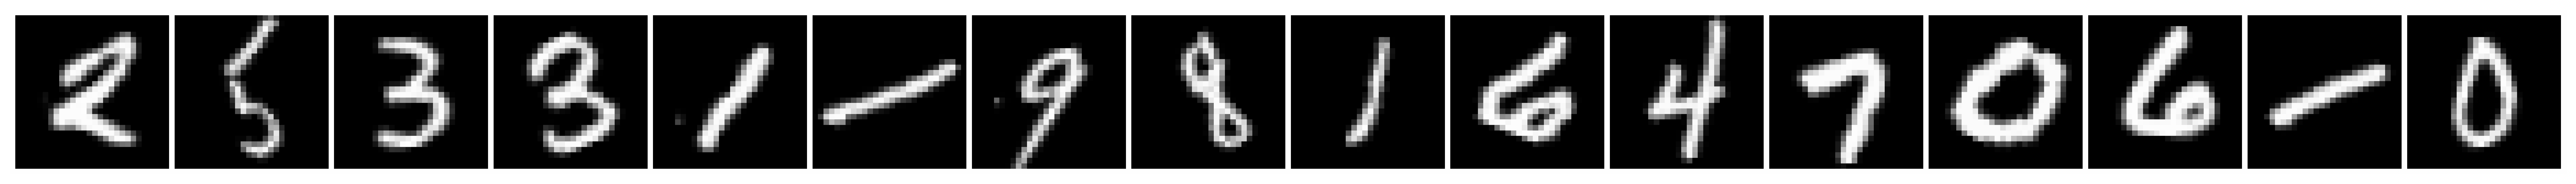

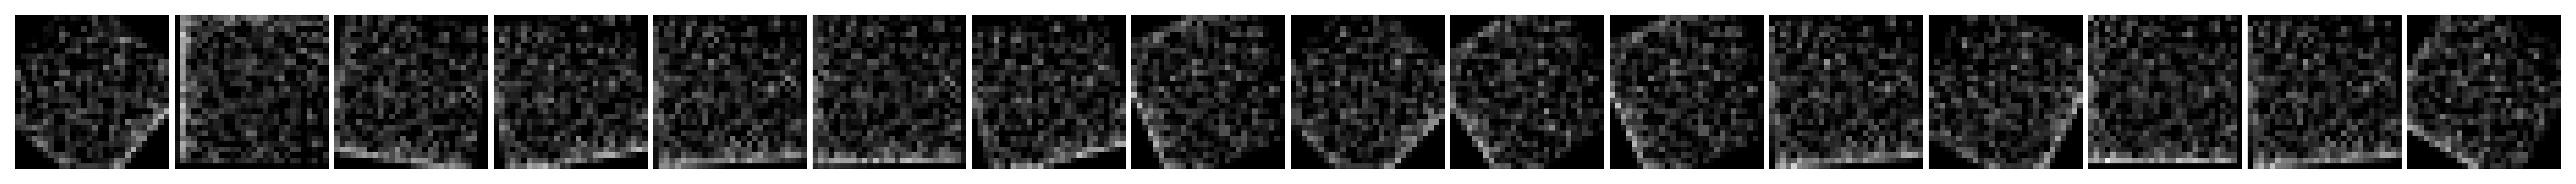

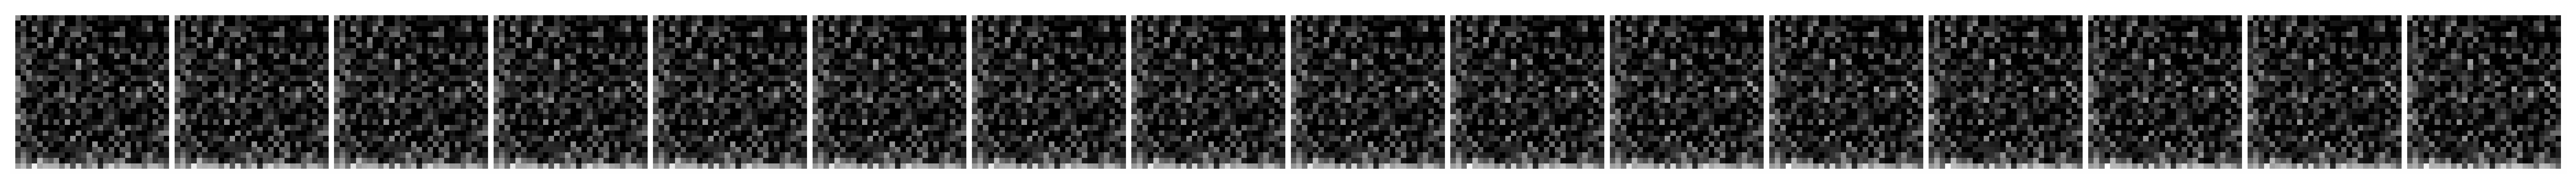

Step   500: loss= 910.364


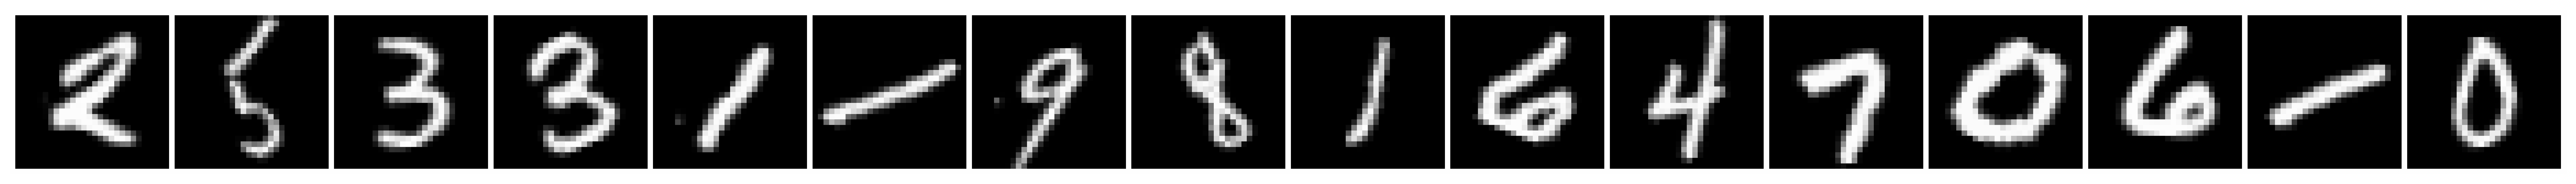

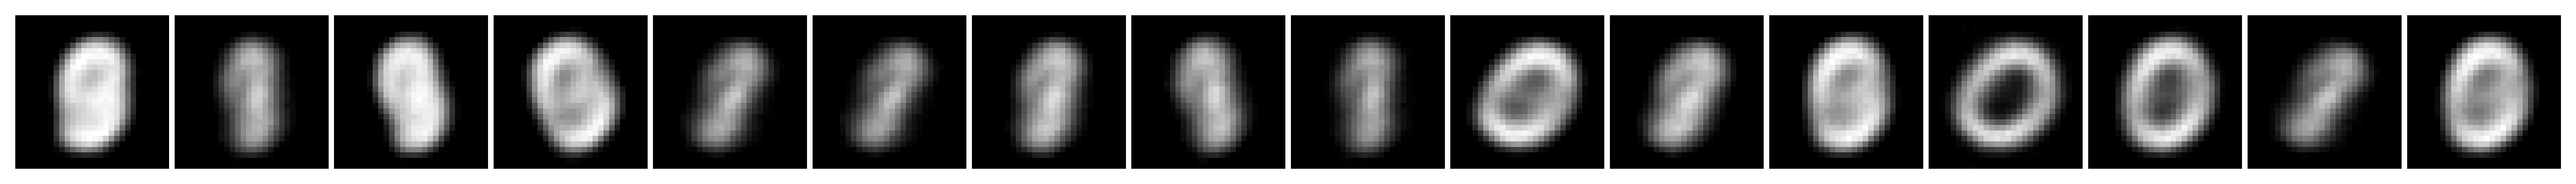

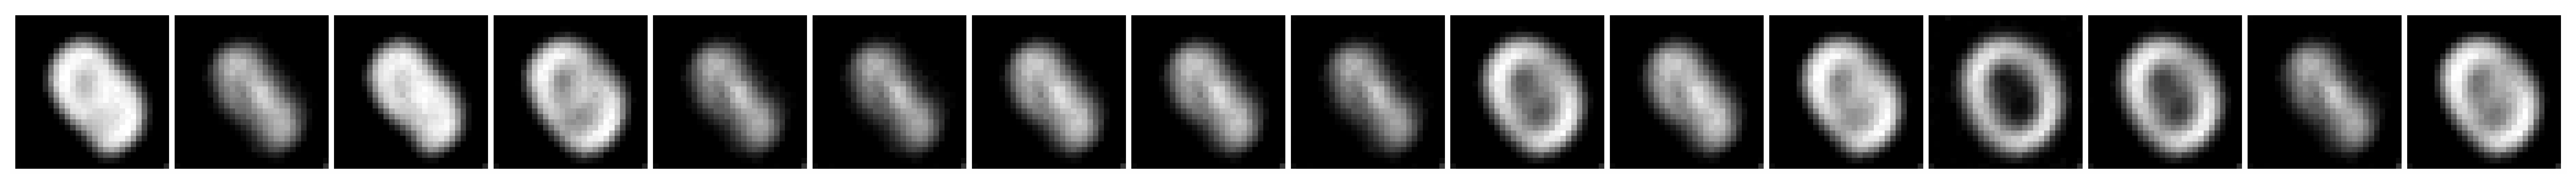

Step  1000: loss= 867.571


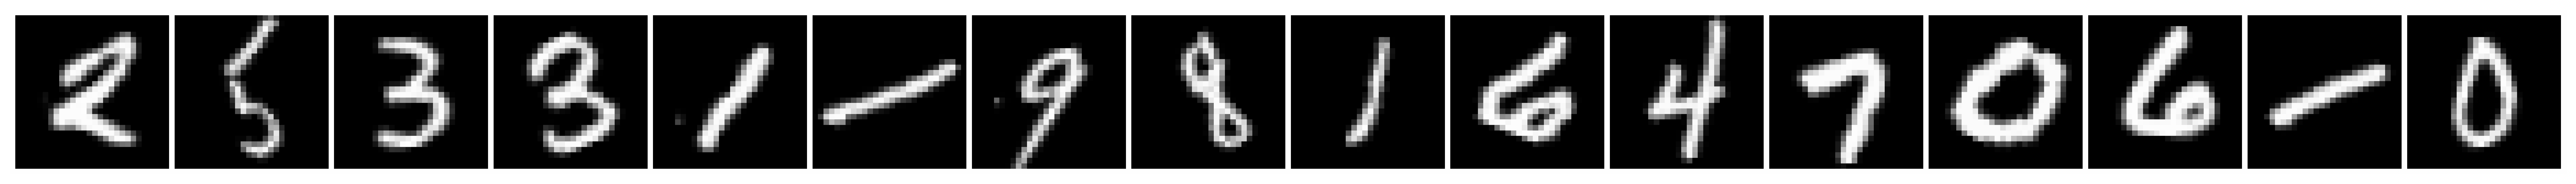

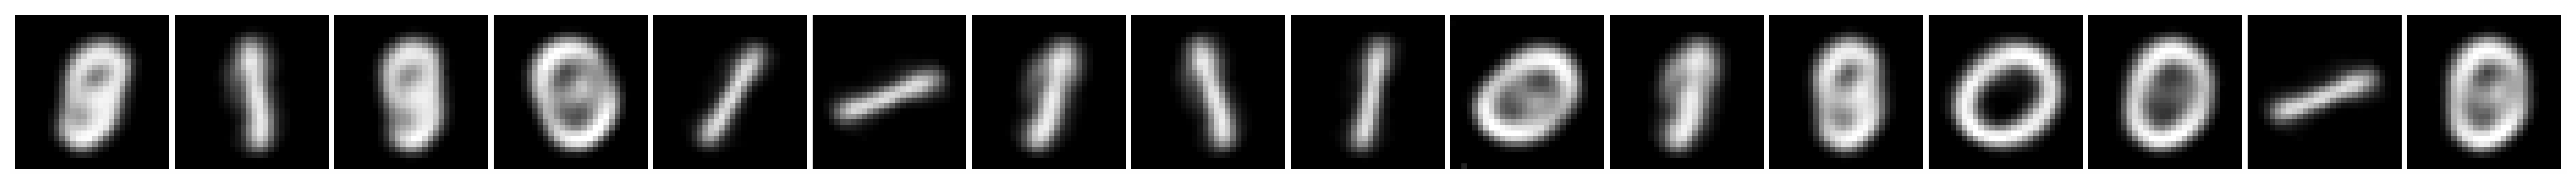

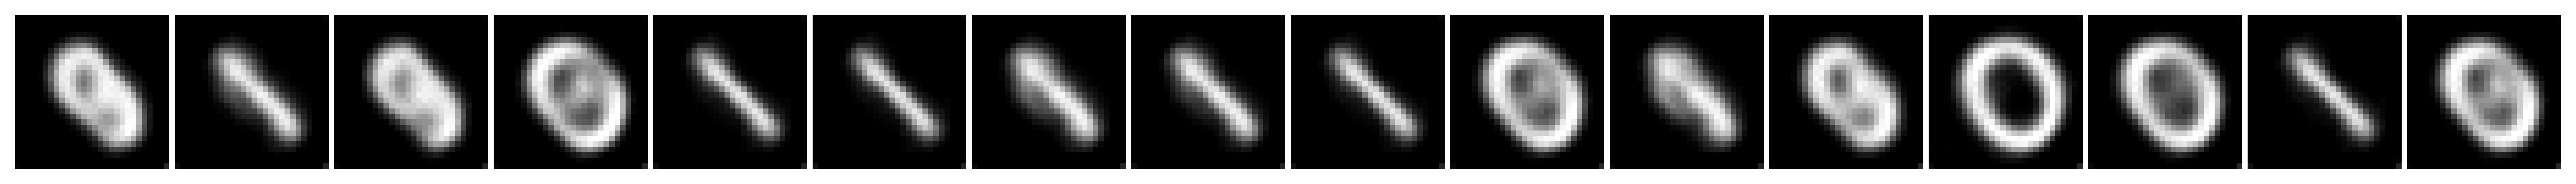

Step  1500: loss= 836.048


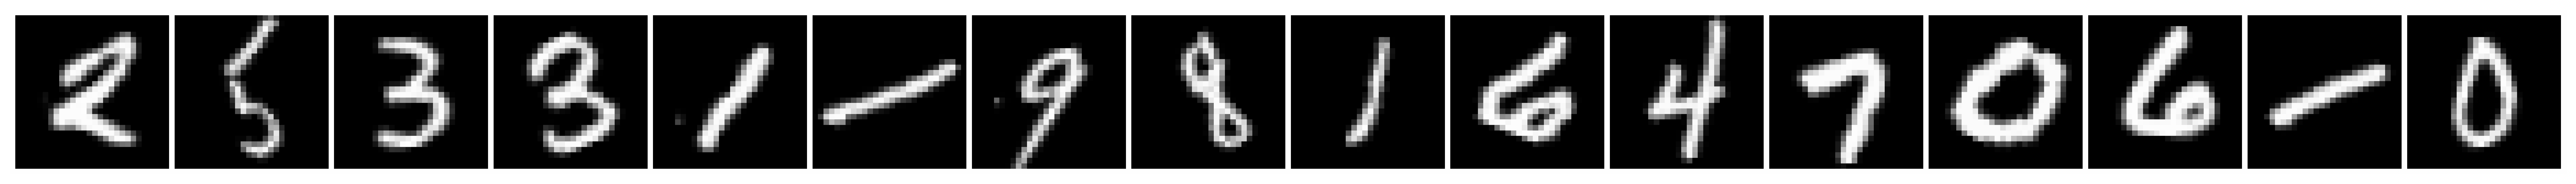

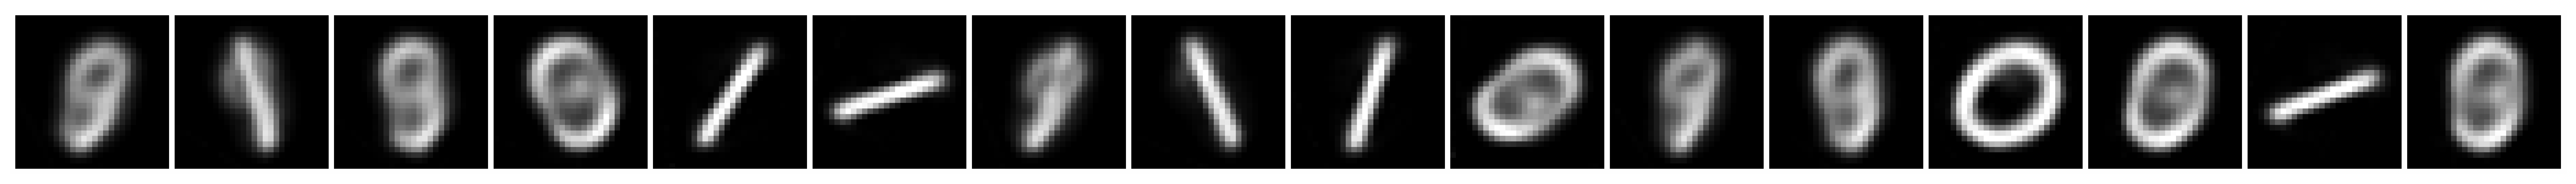

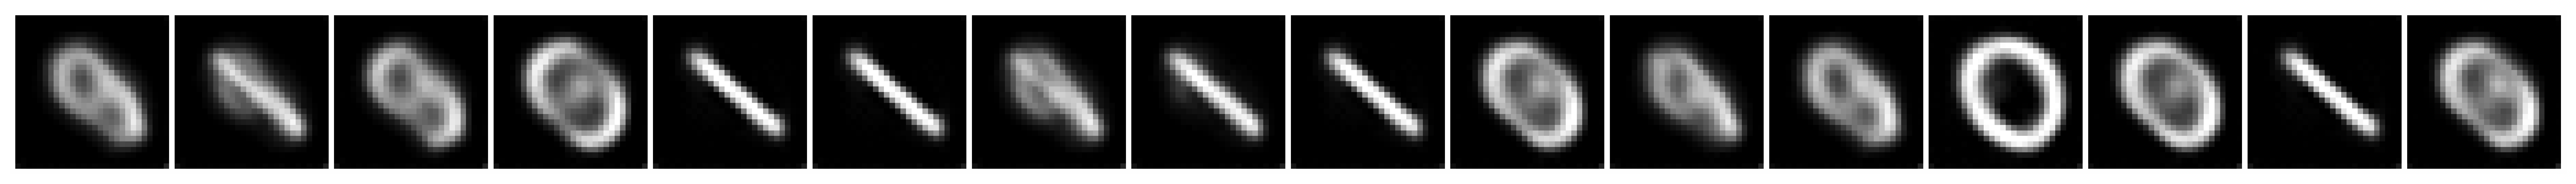

Step  2000: loss= 825.737


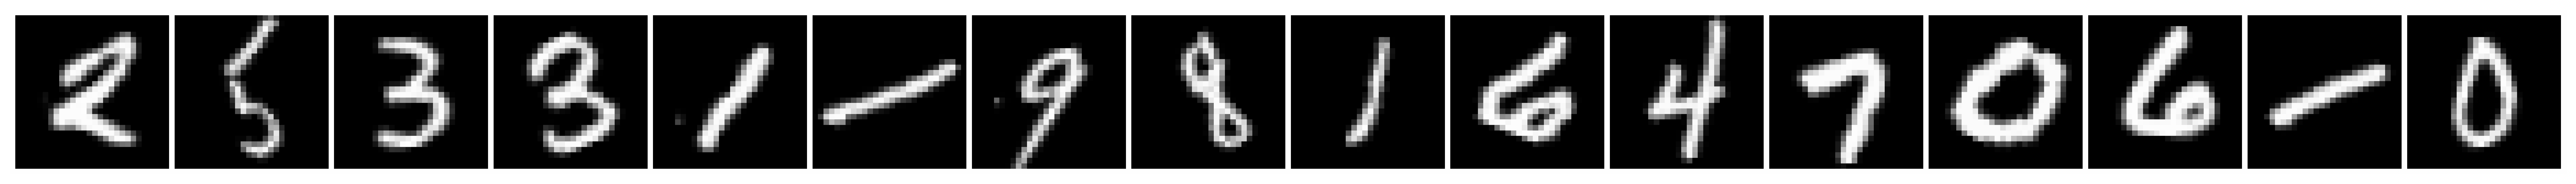

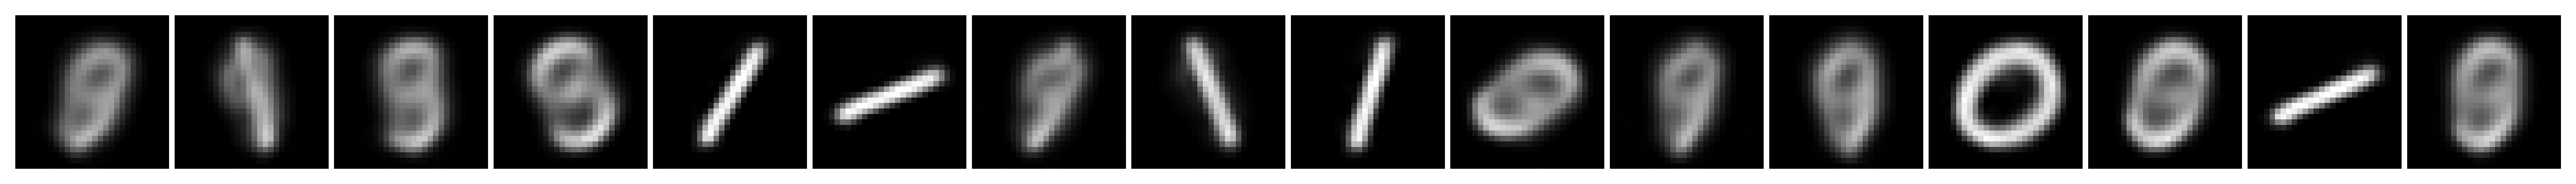

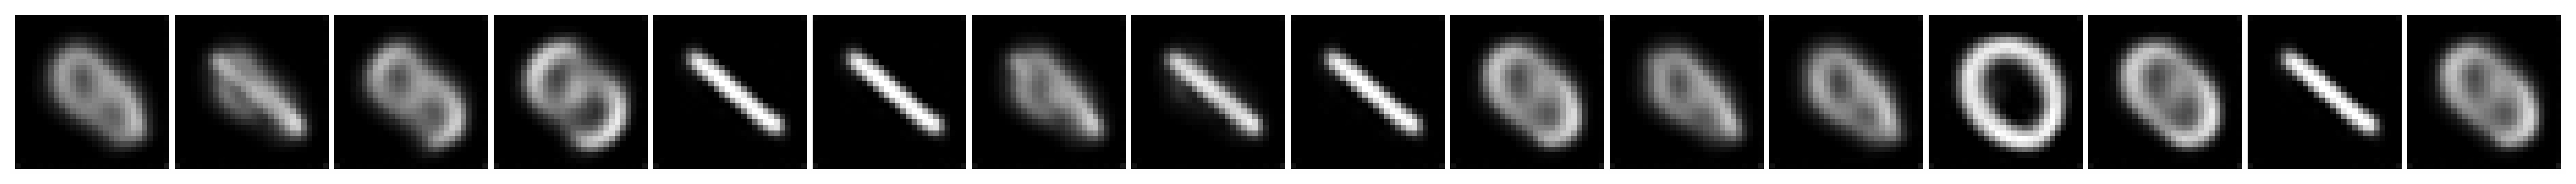

Step  2500: loss= 818.027


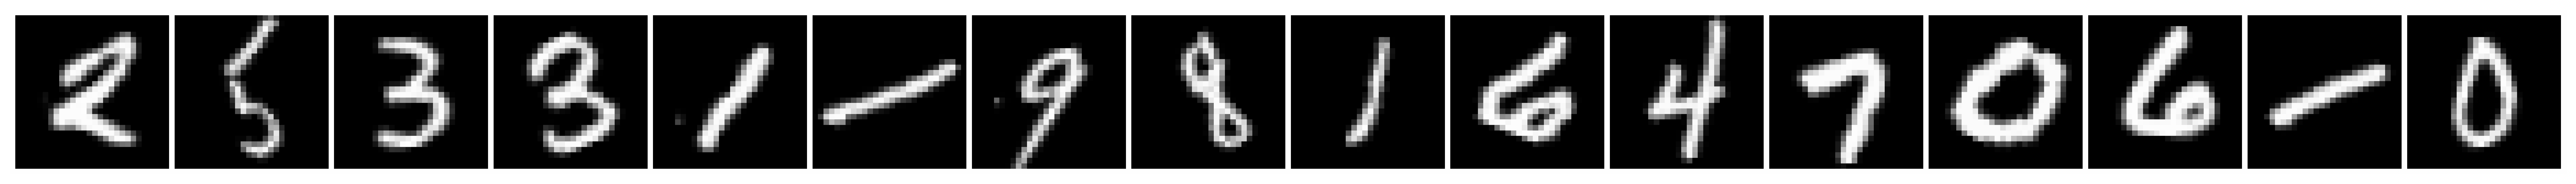

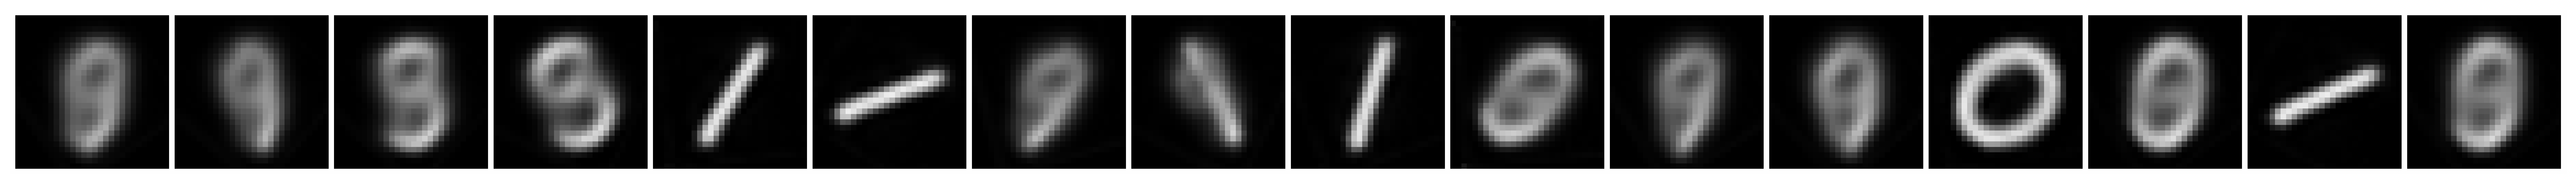

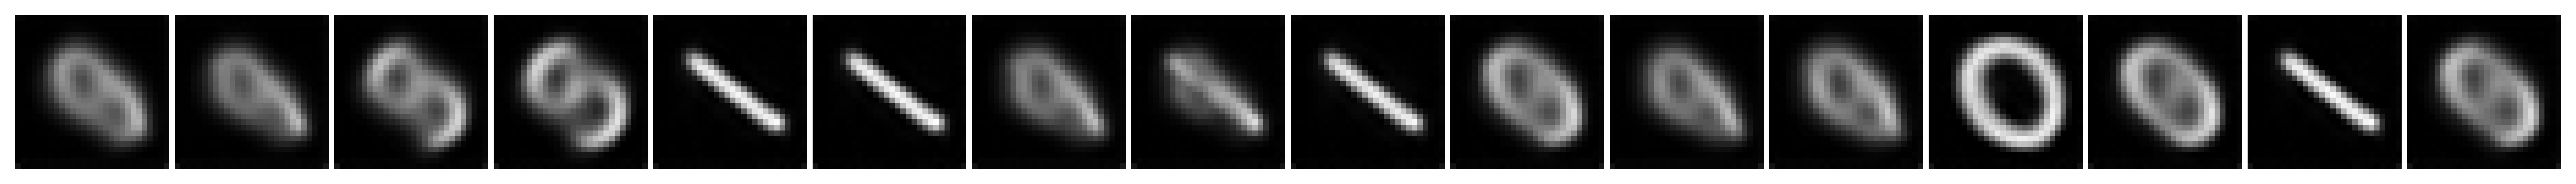

Step  3000: loss= 808.116


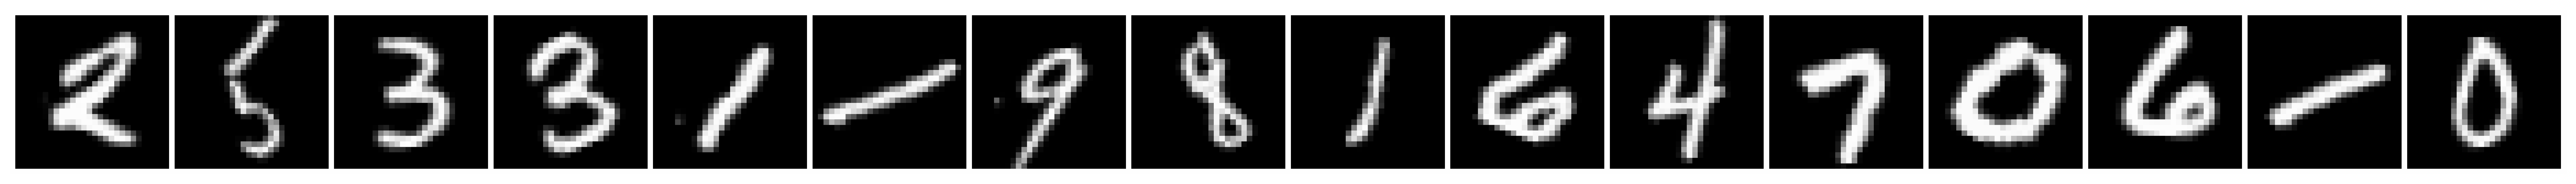

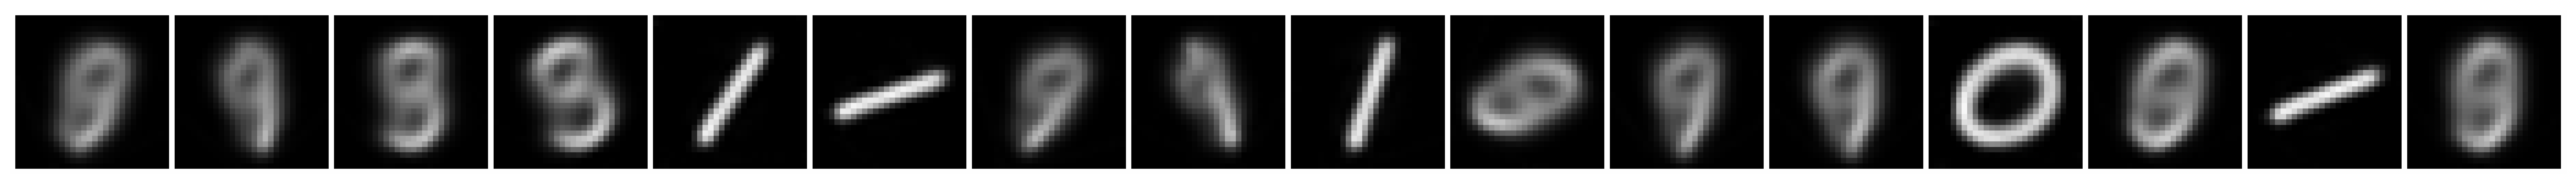

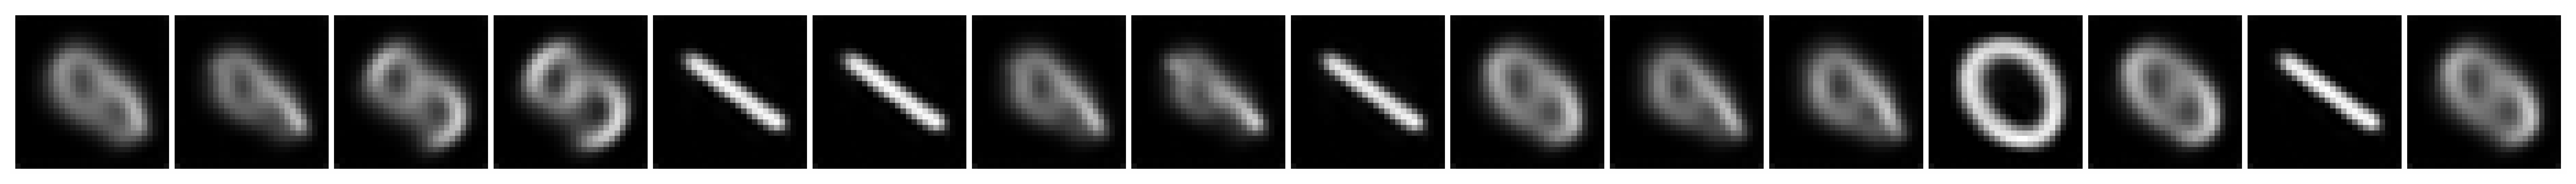

Step  3500: loss= 807.360


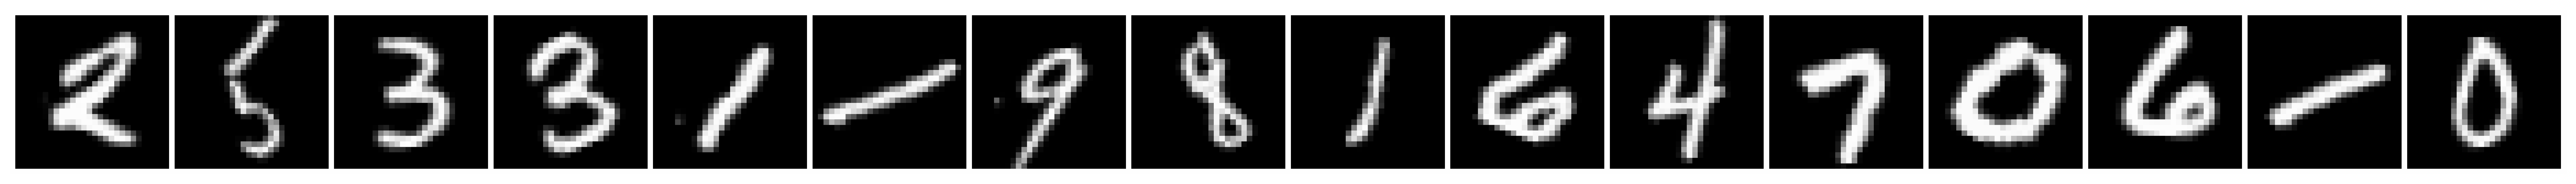

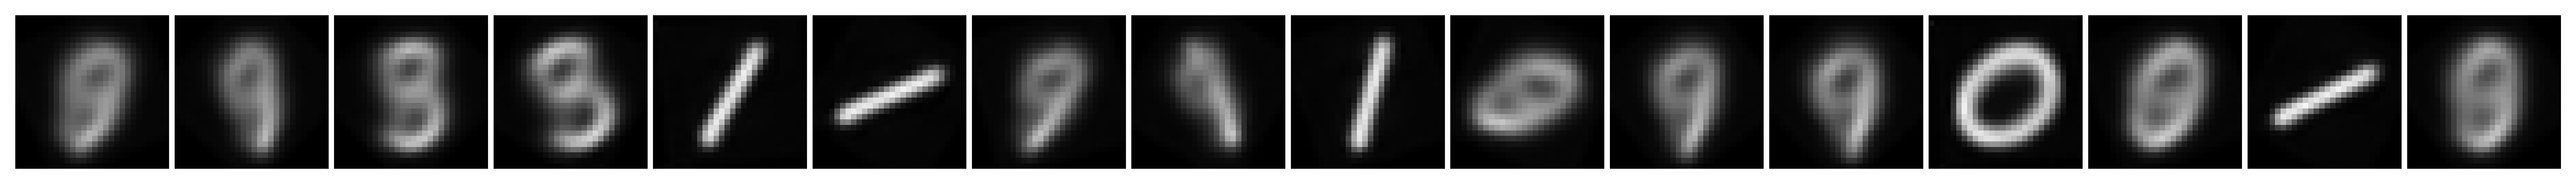

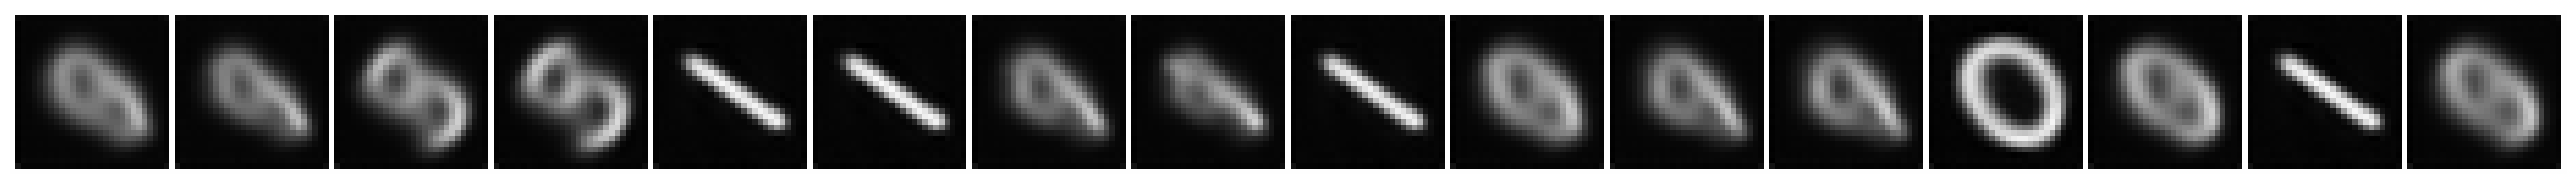

Step  4000: loss= 803.578


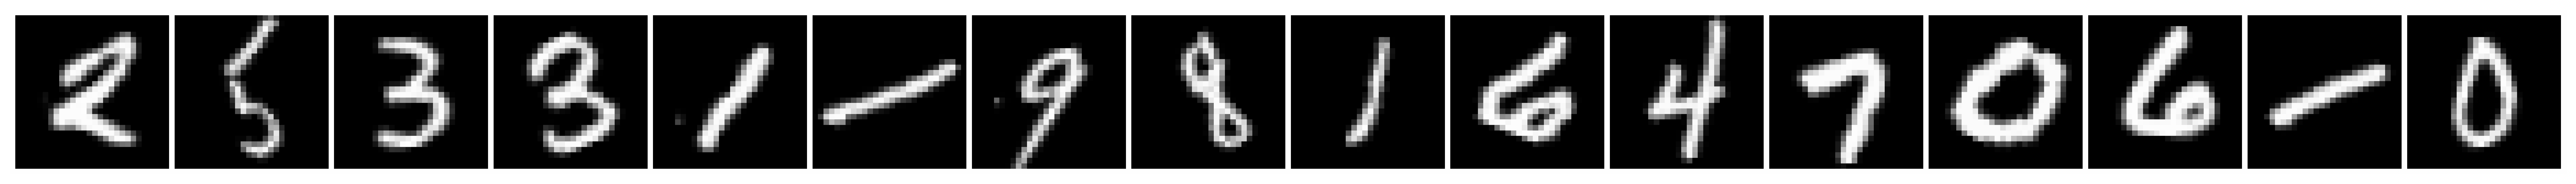

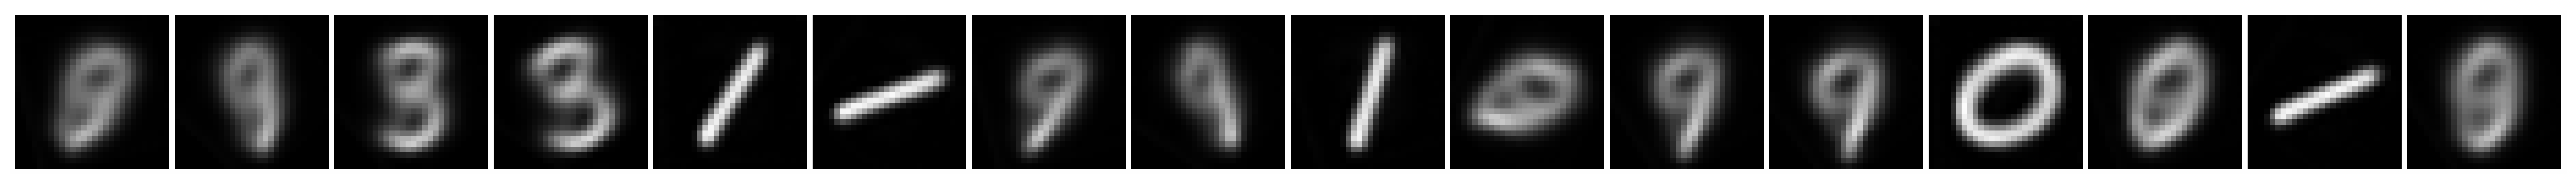

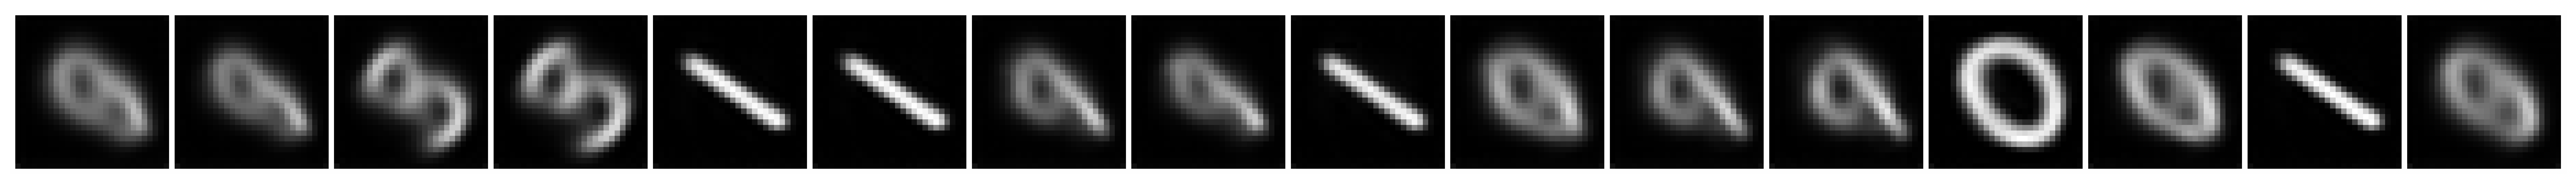

Step  4500: loss= 802.974


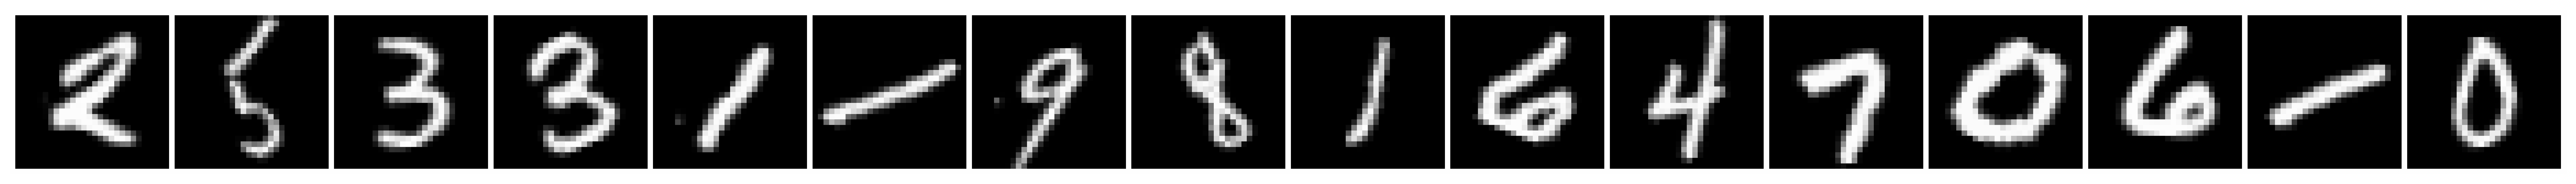

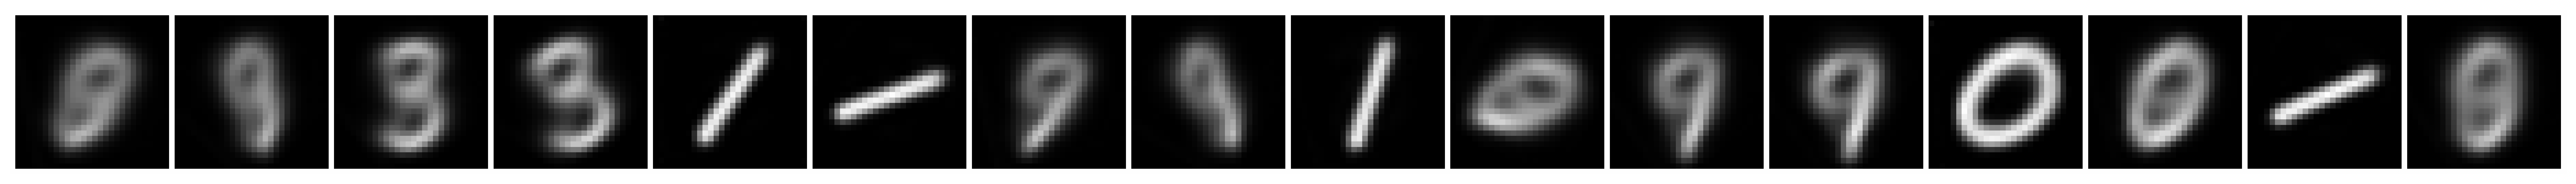

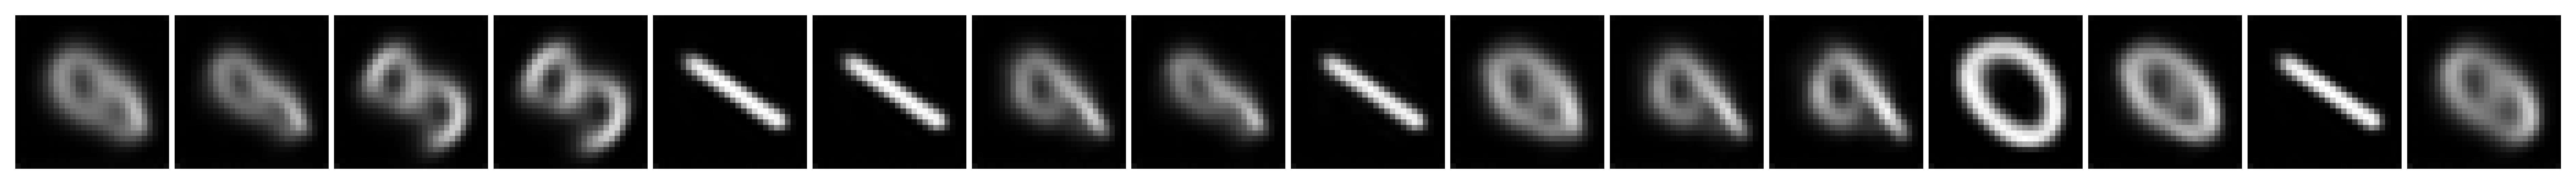

Step  5000: loss= 798.793


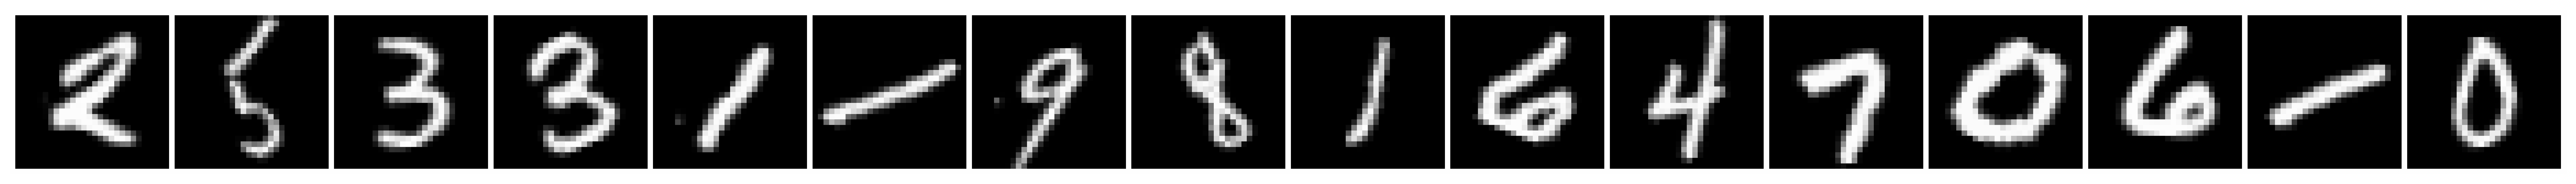

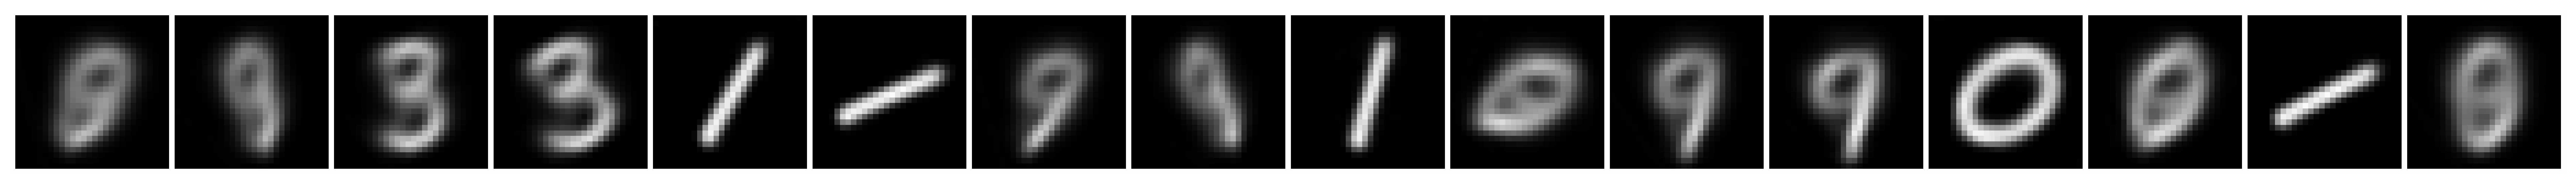

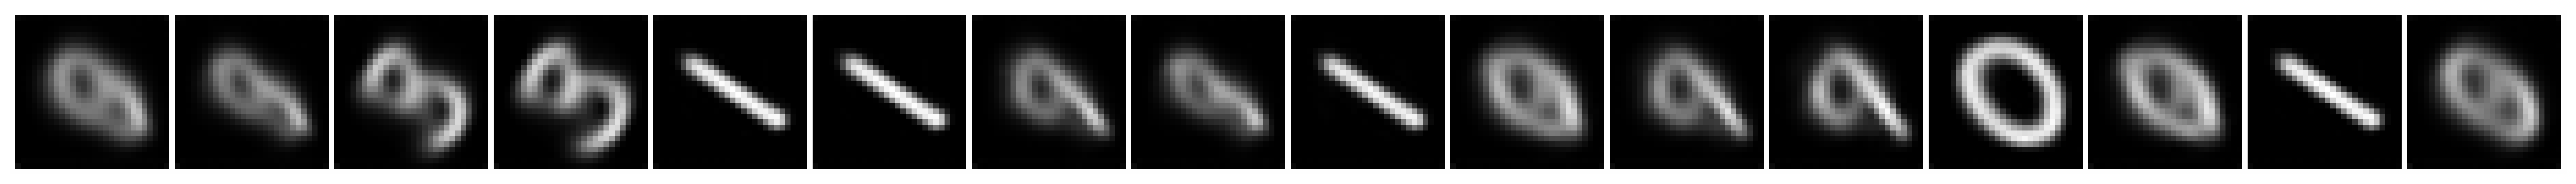

Step  5500: loss= 799.674


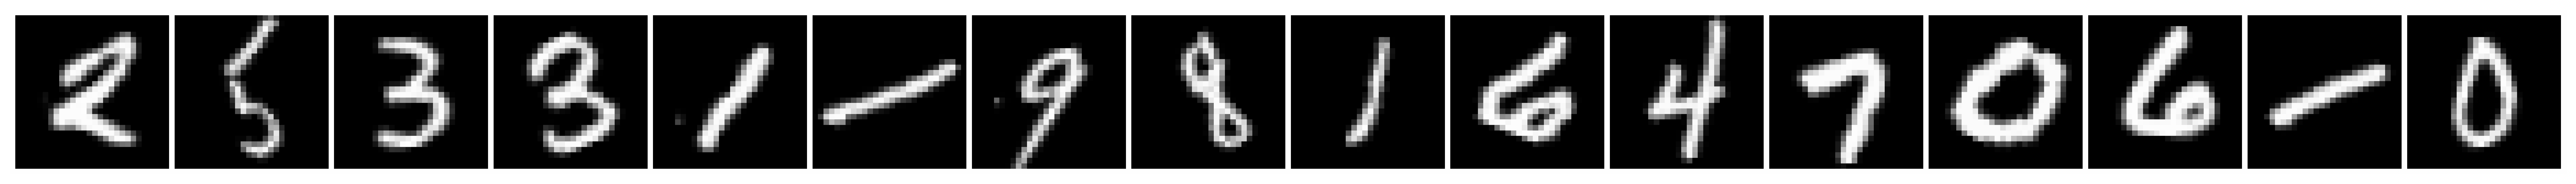

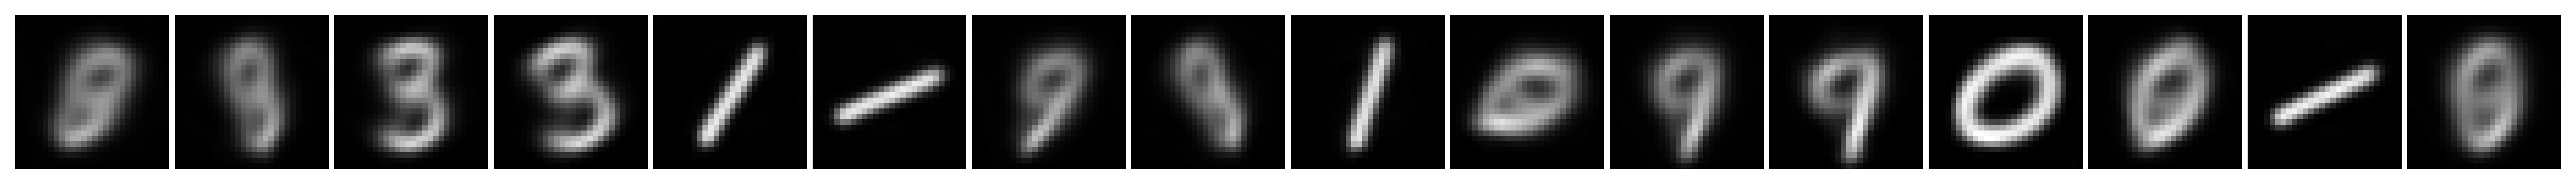

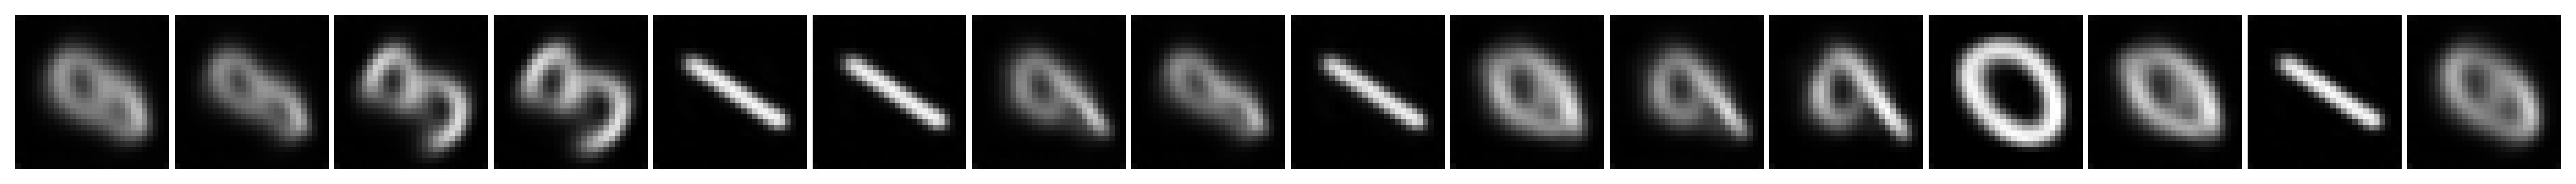

Step  6000: loss= 794.244


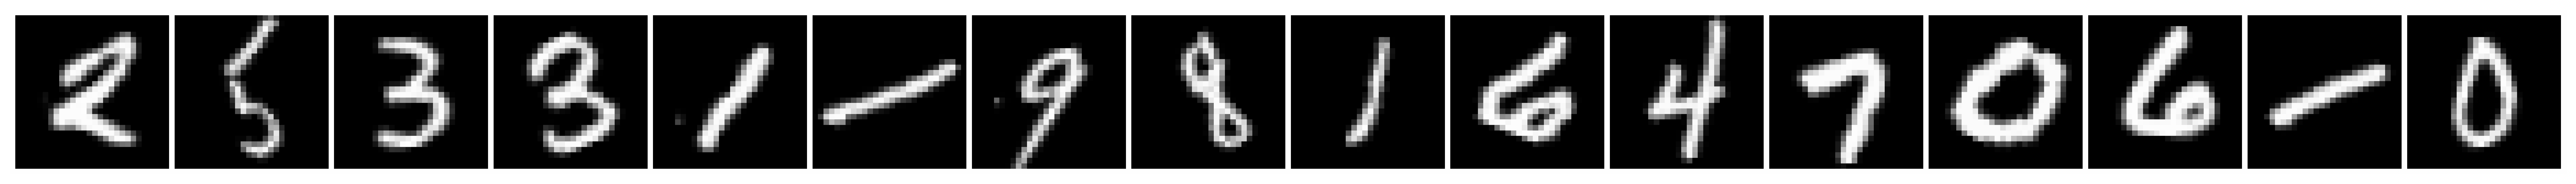

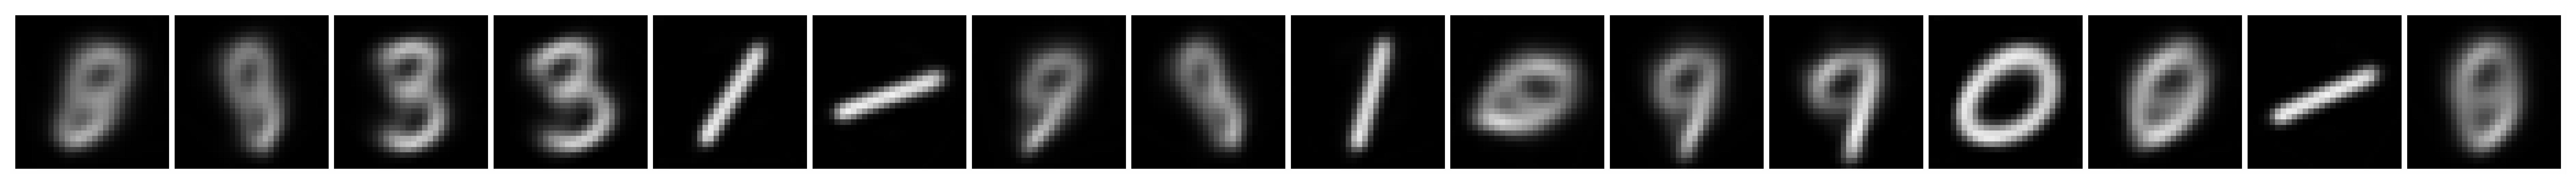

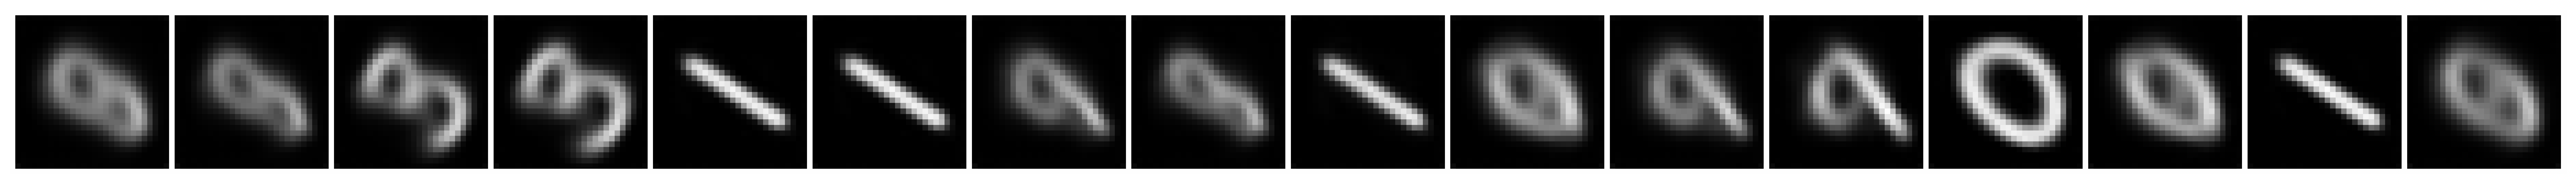

Step  6500: loss= 796.133


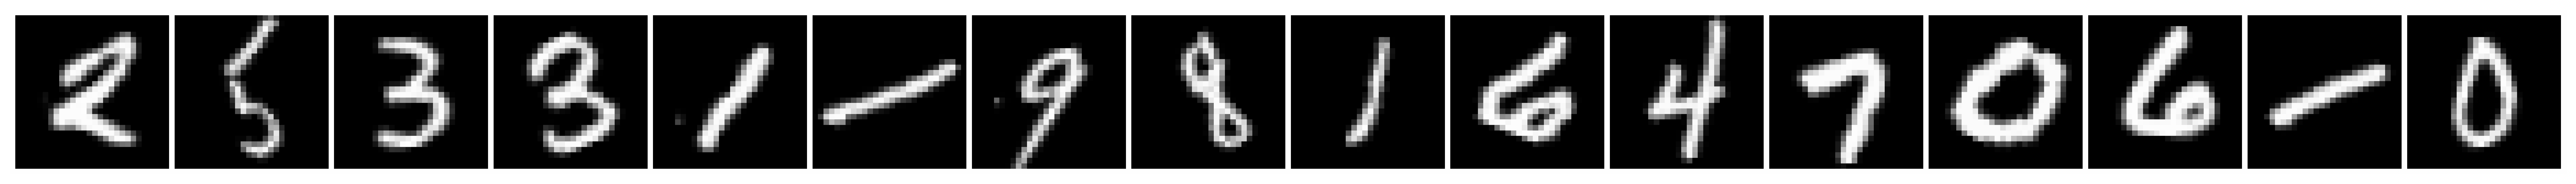

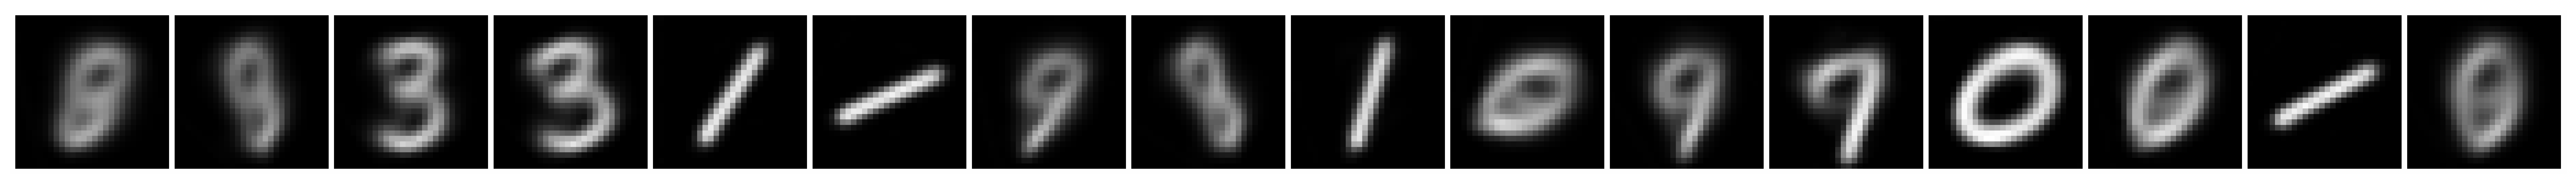

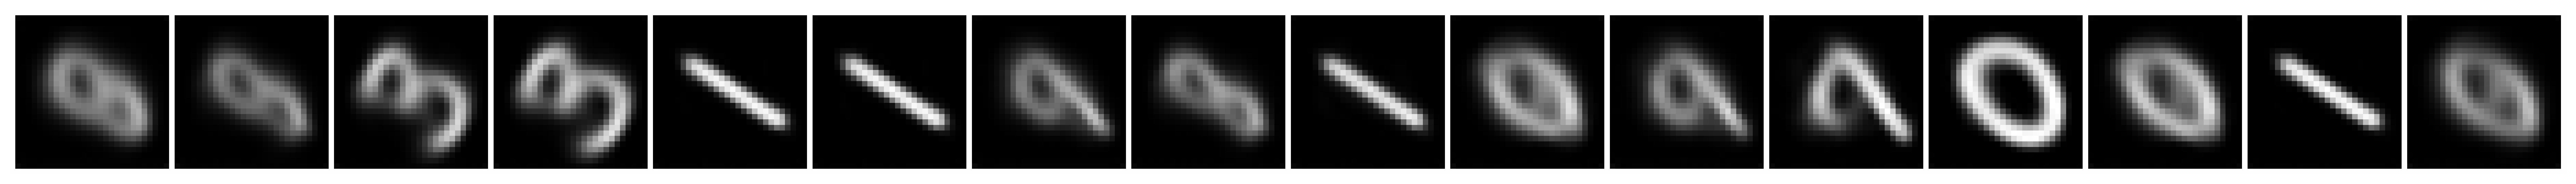

Step  7000: loss= 795.561


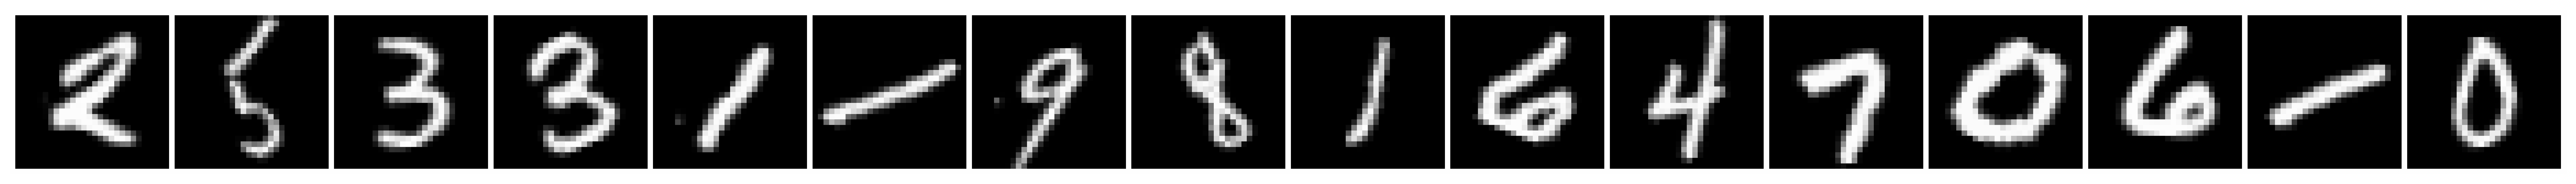

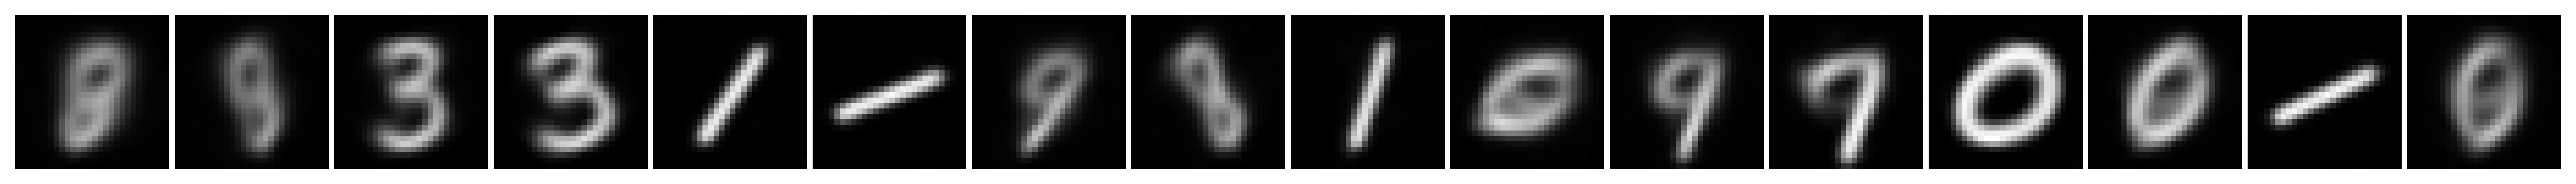

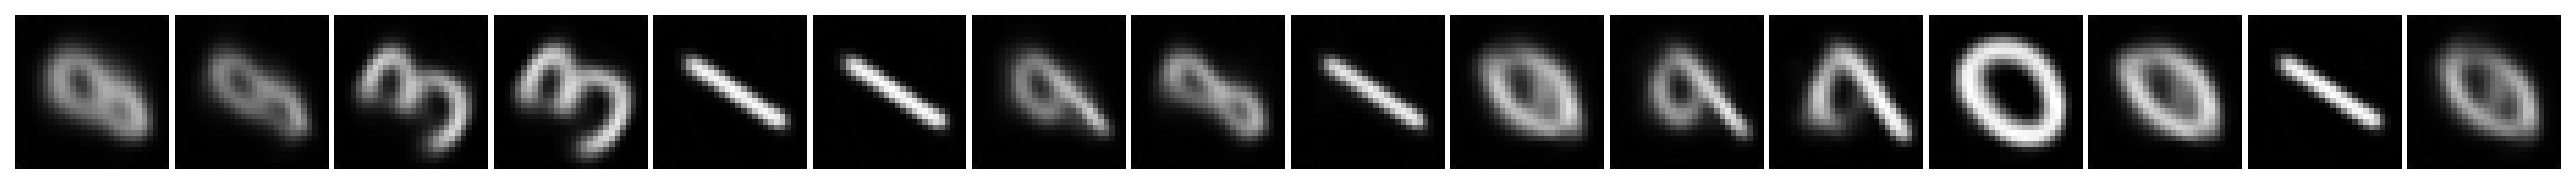

Step  7500: loss= 792.163


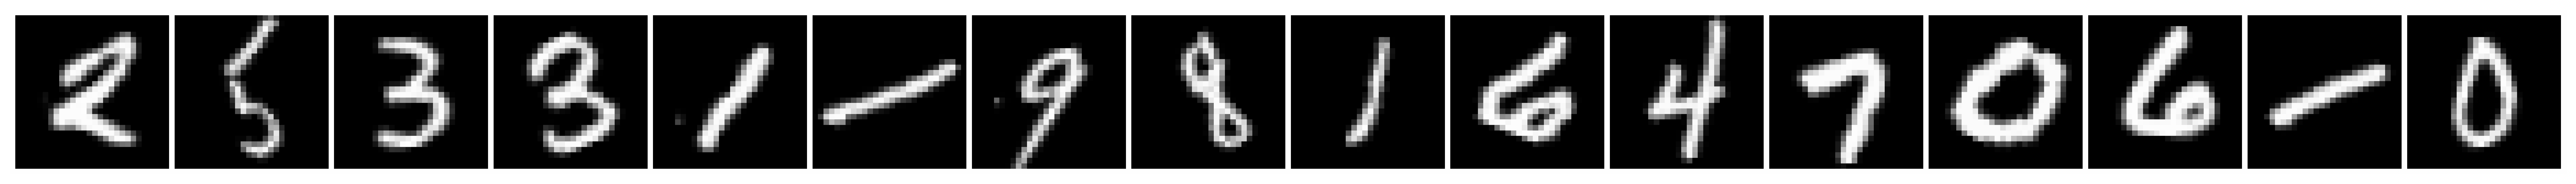

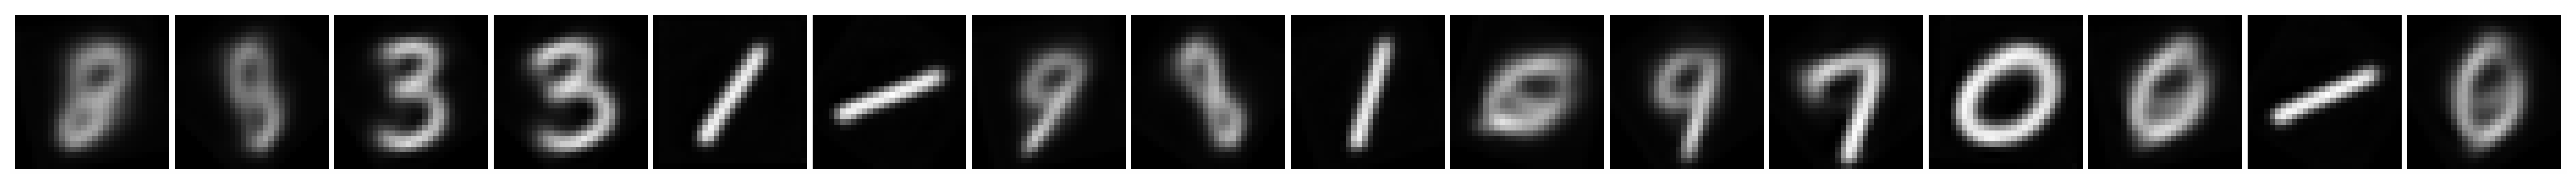

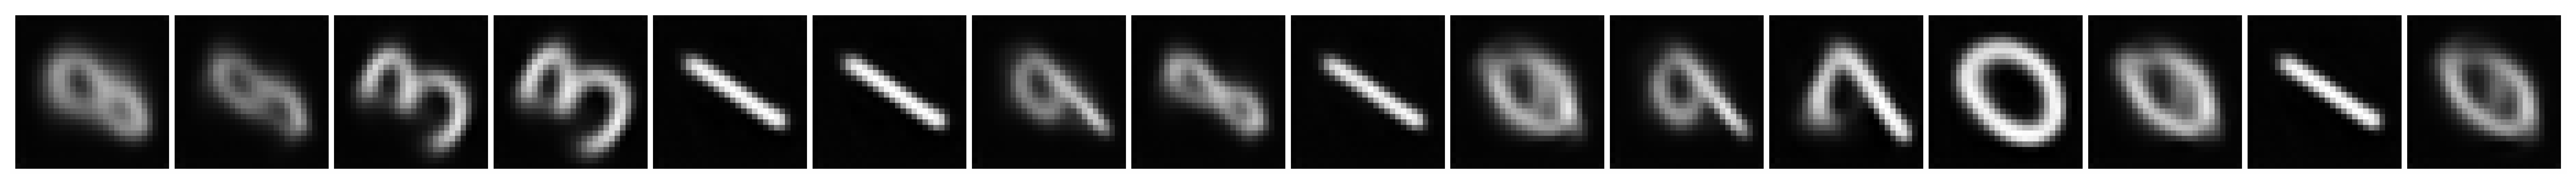

Step  8000: loss= 789.244


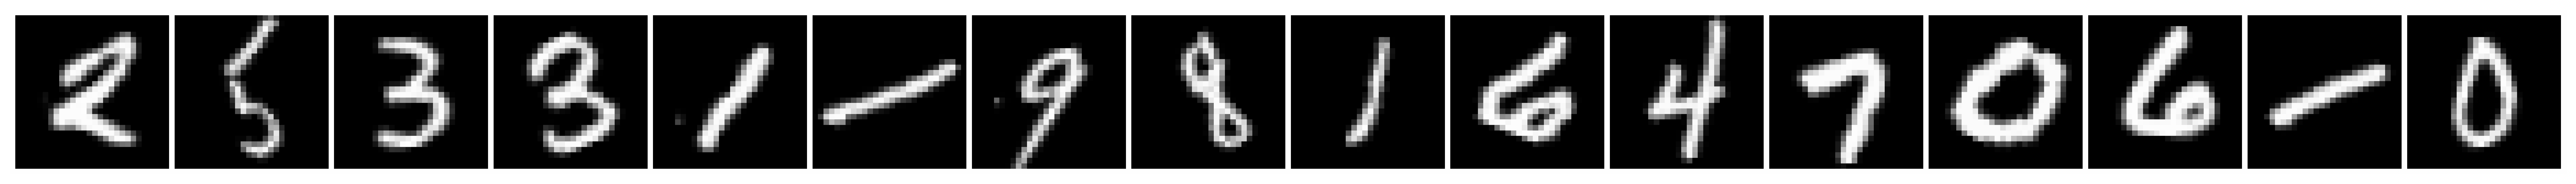

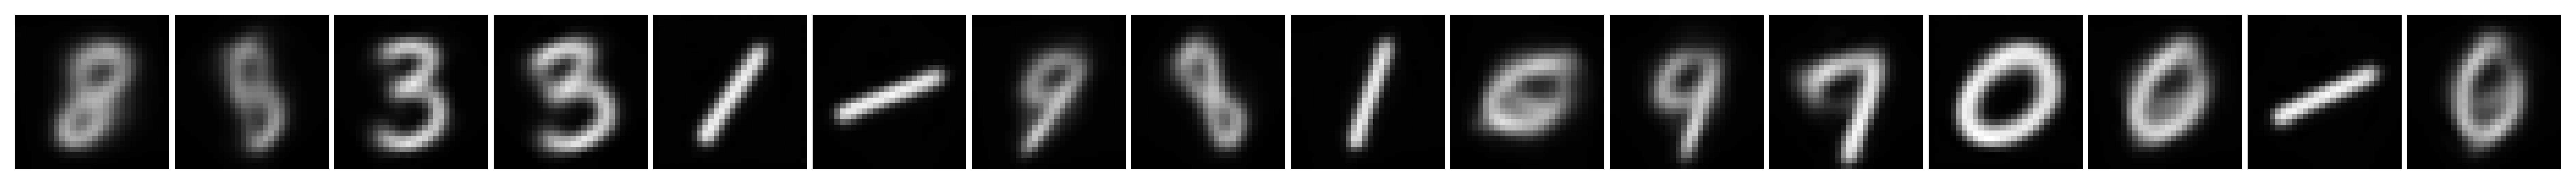

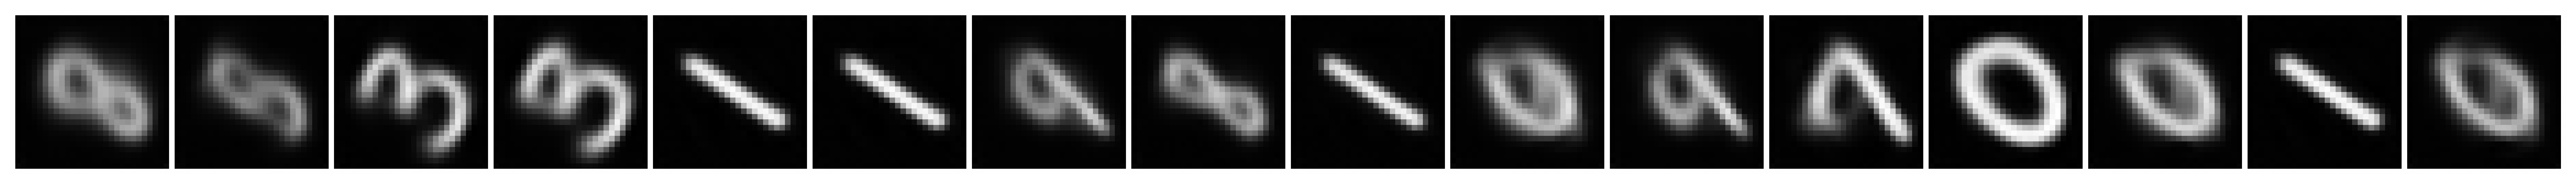

Step  8500: loss= 786.698


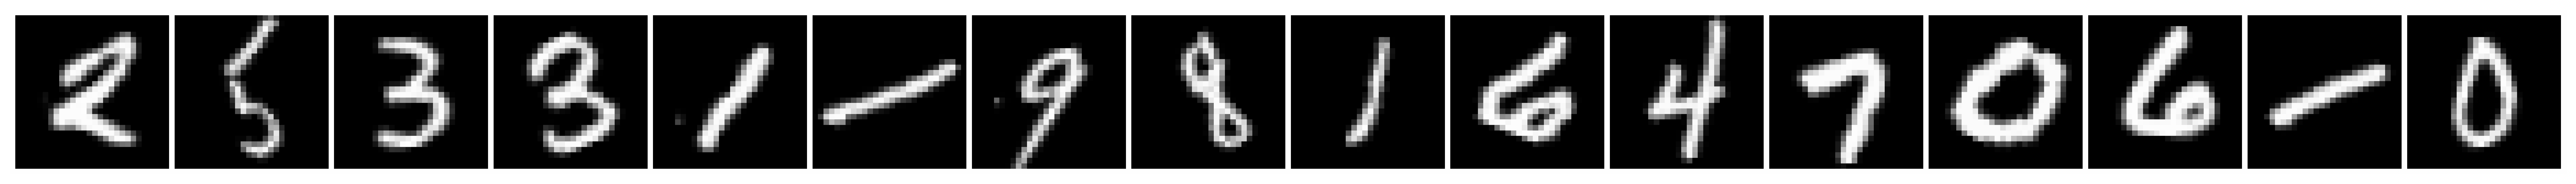

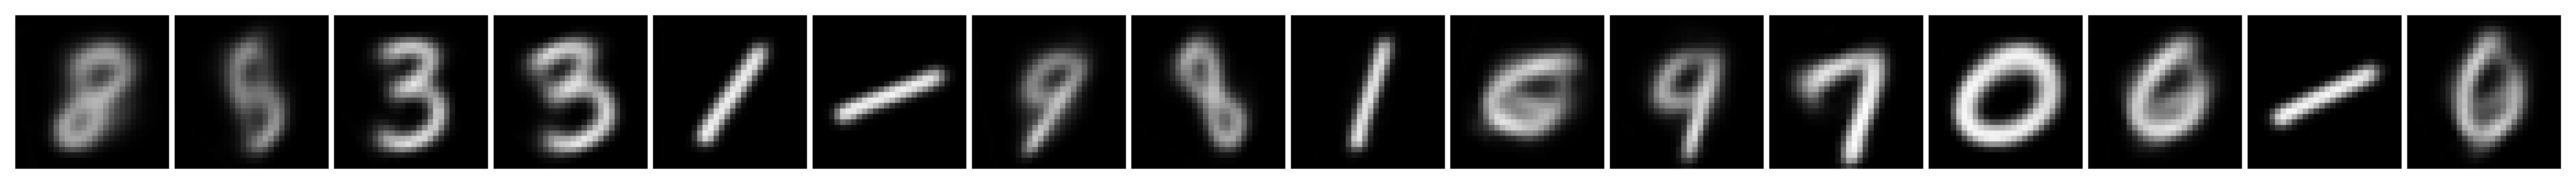

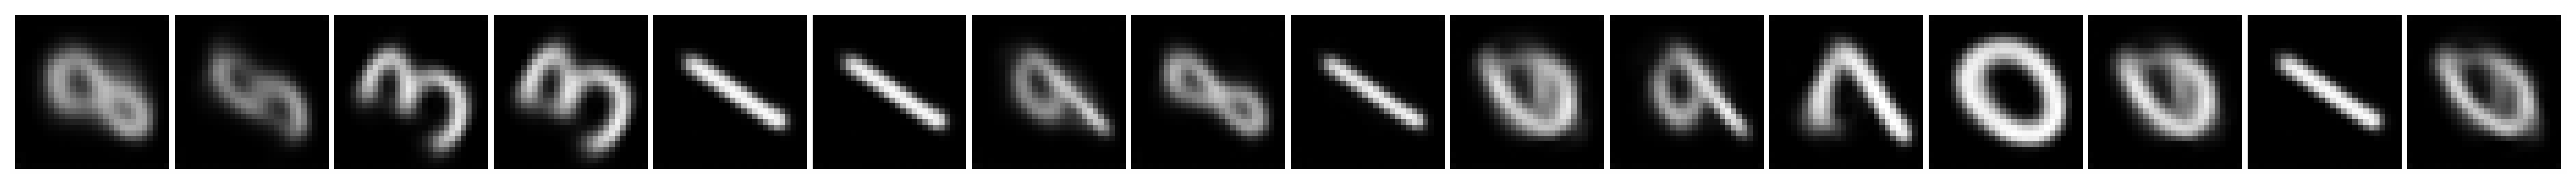

Step  9000: loss= 787.677


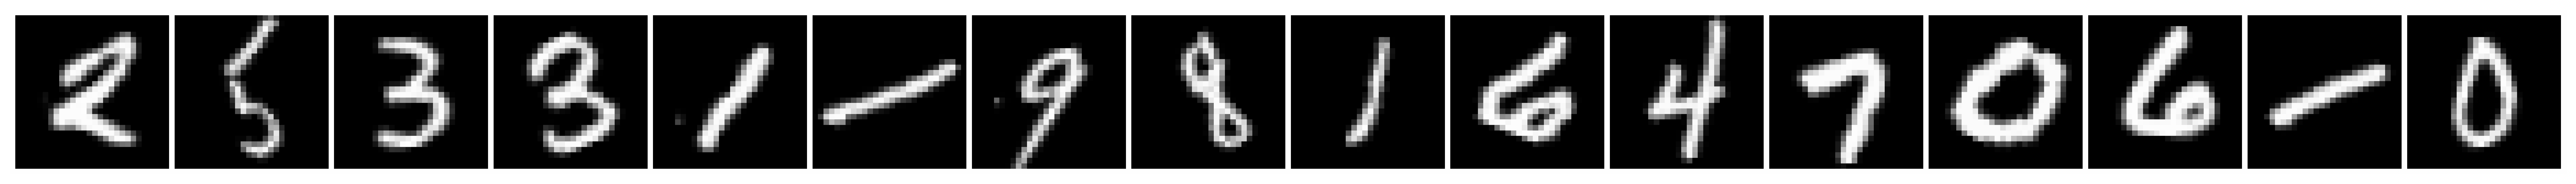

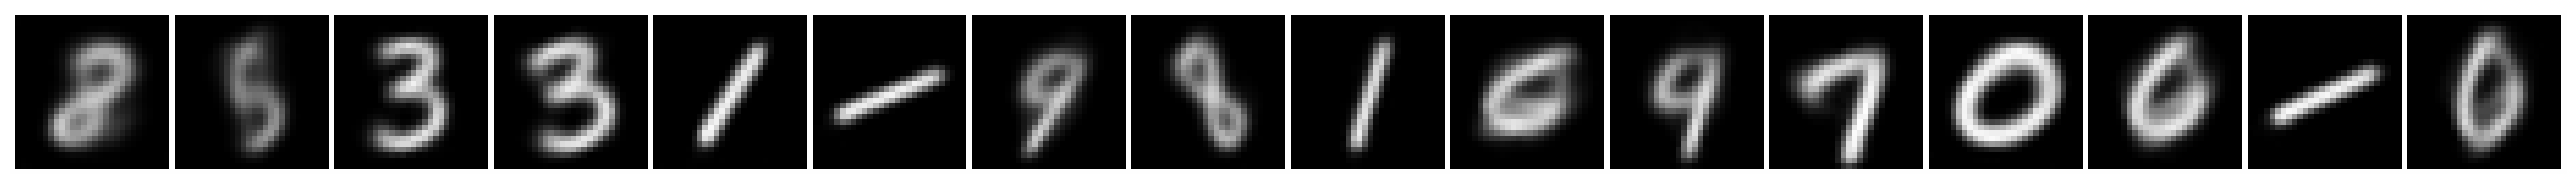

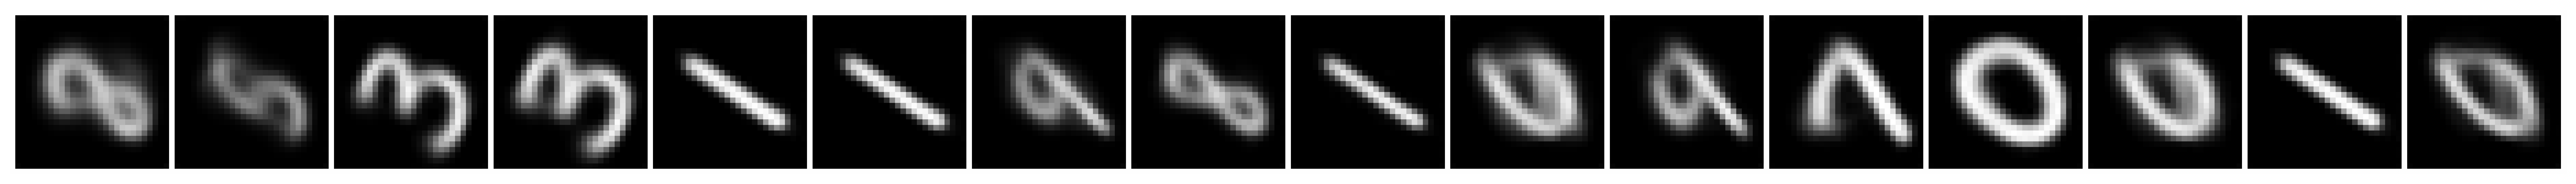

Step  9500: loss= 784.431


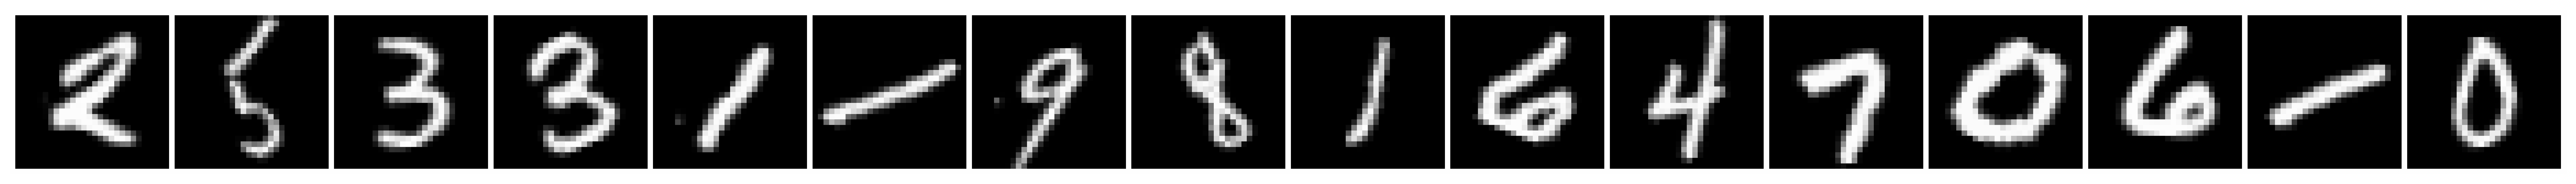

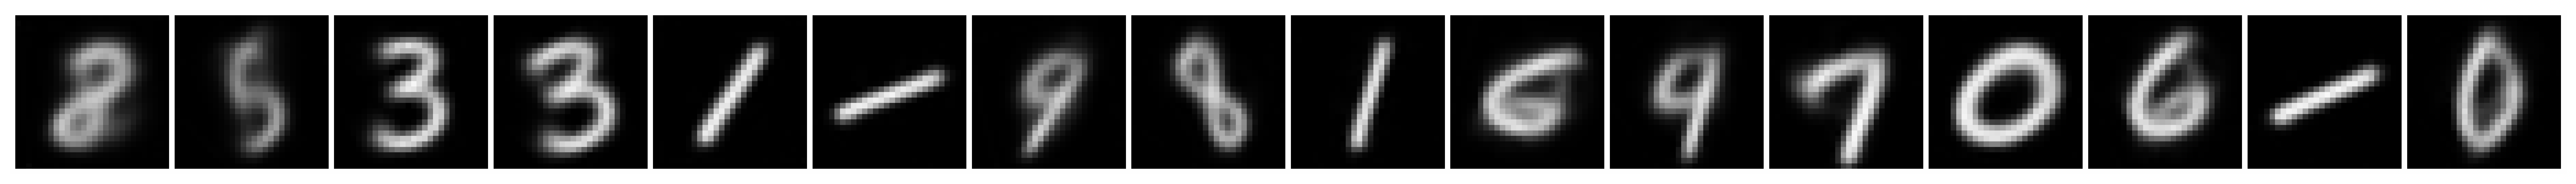

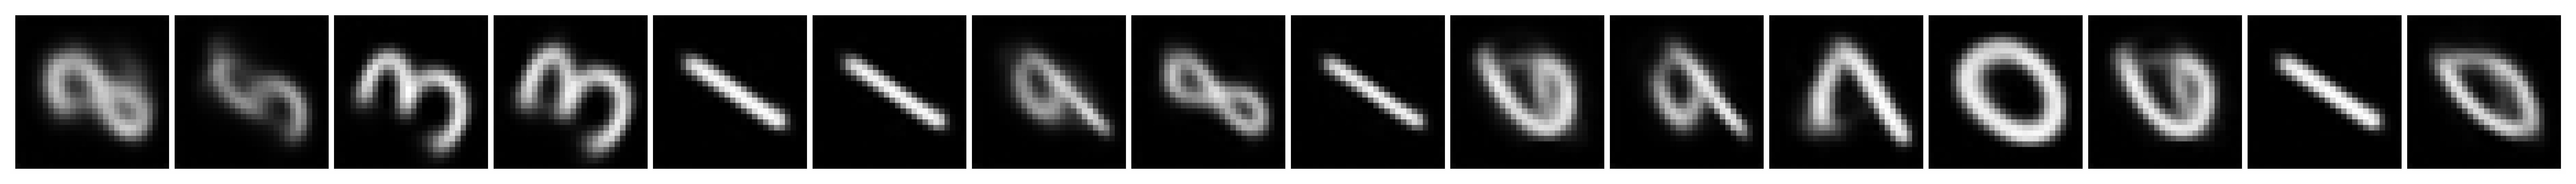

Step 10000: loss= 780.172


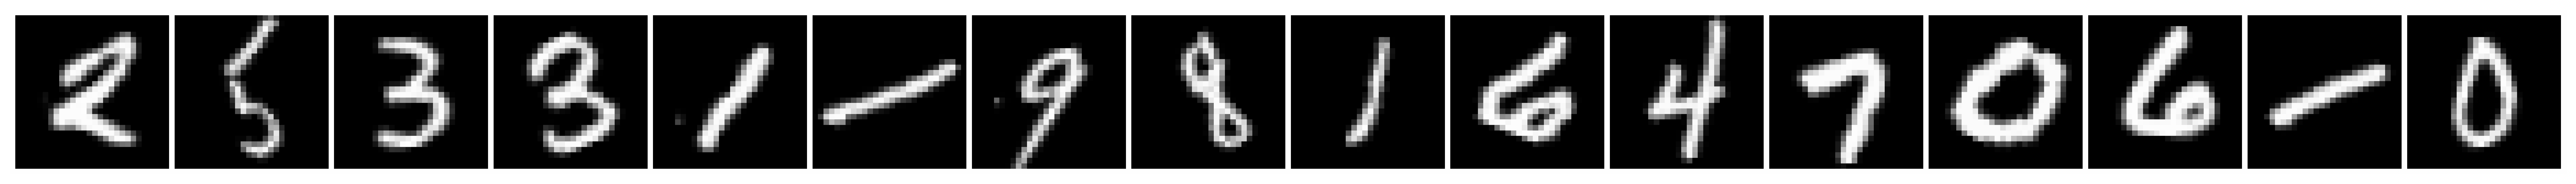

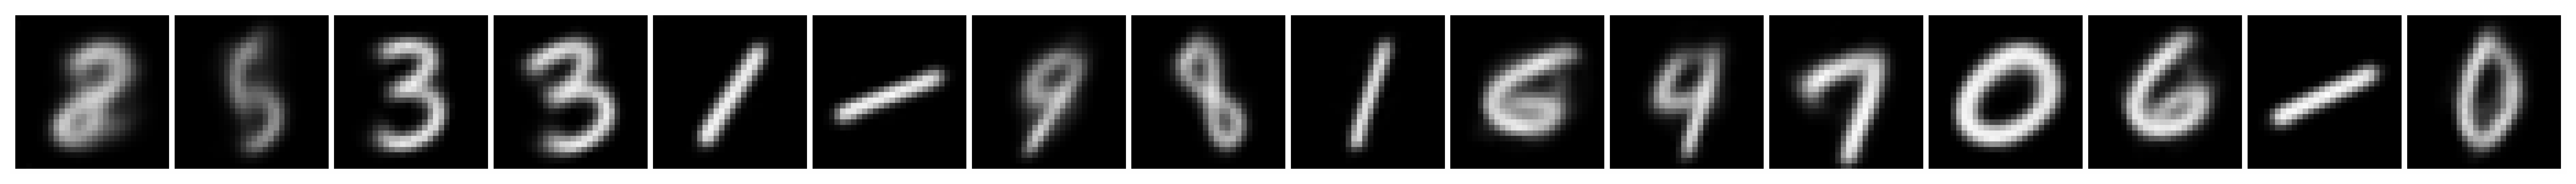

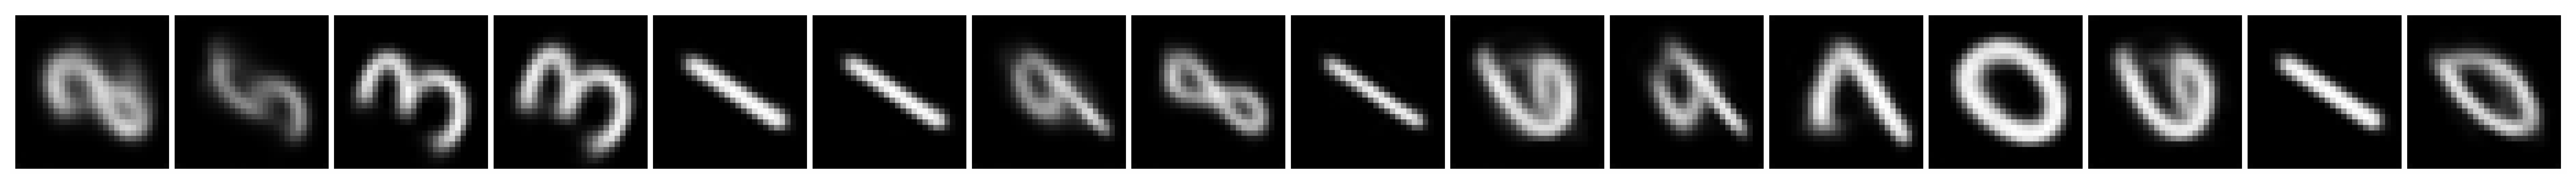

Step 10500: loss= 779.789


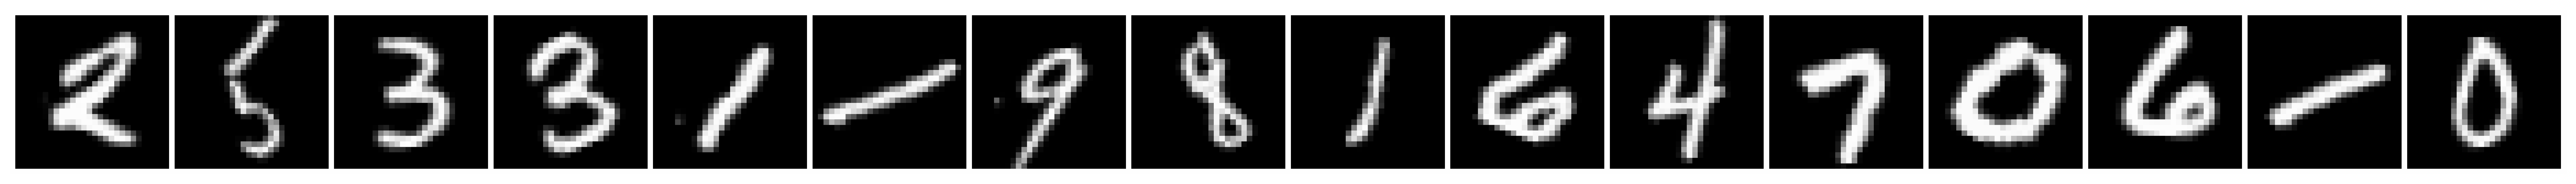

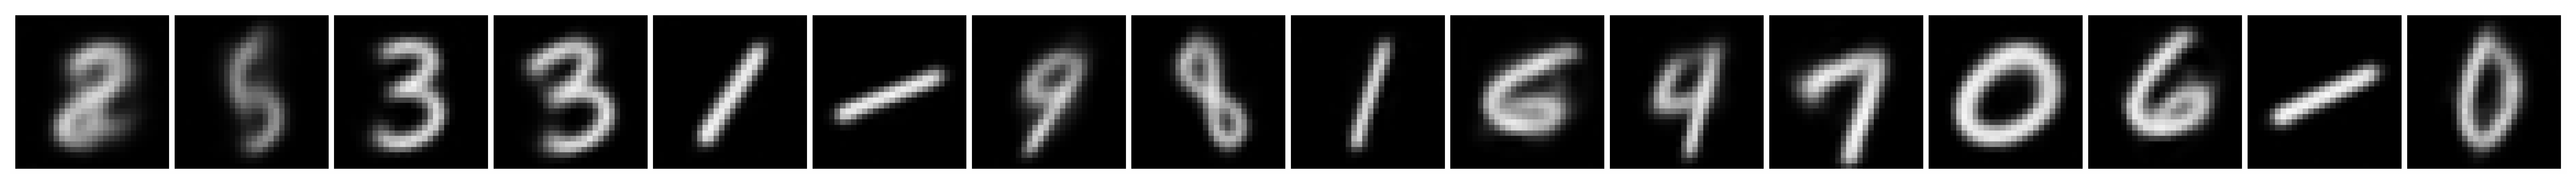

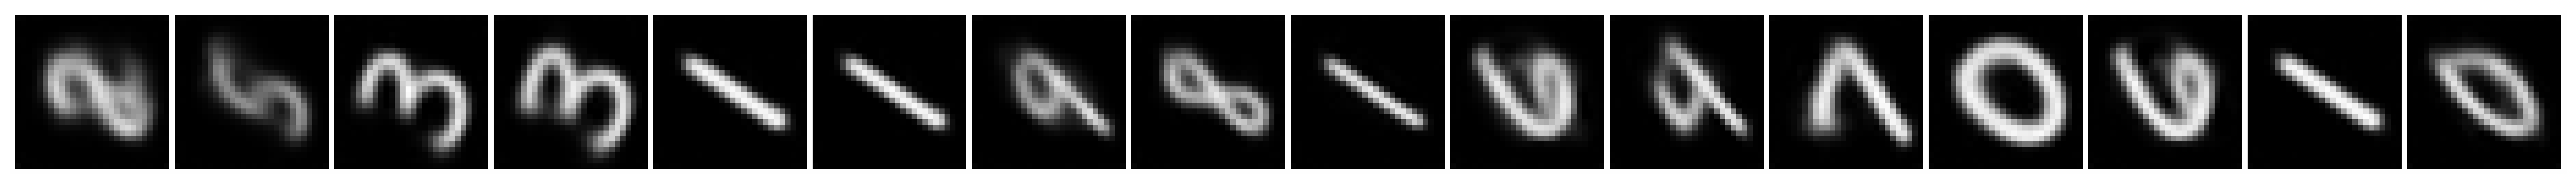

Step 11000: loss= 775.658


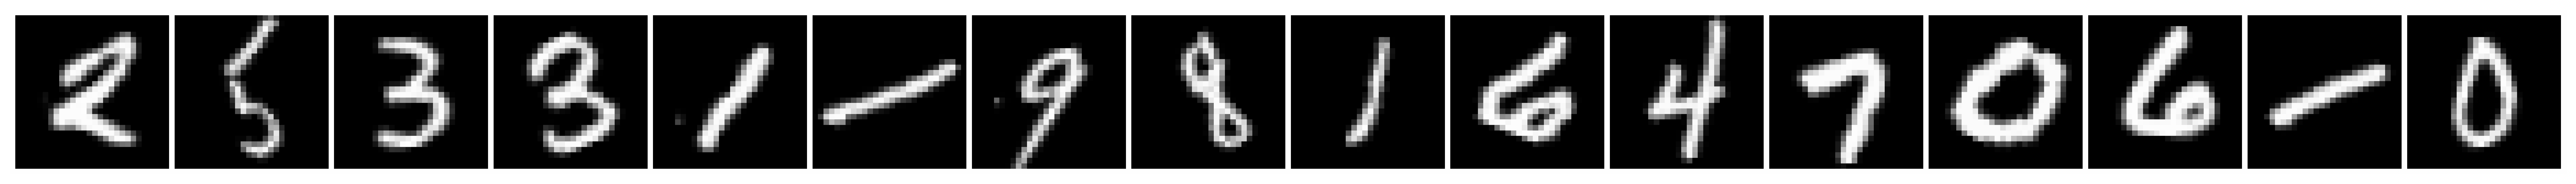

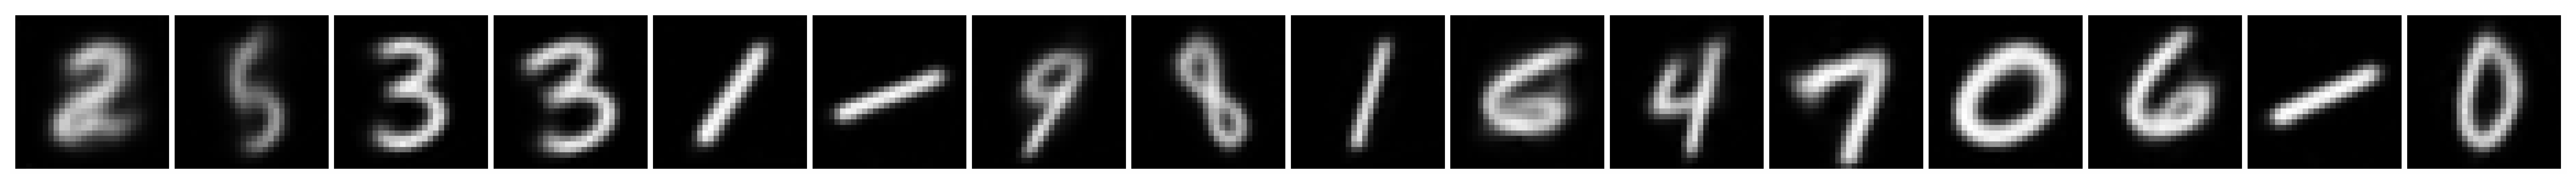

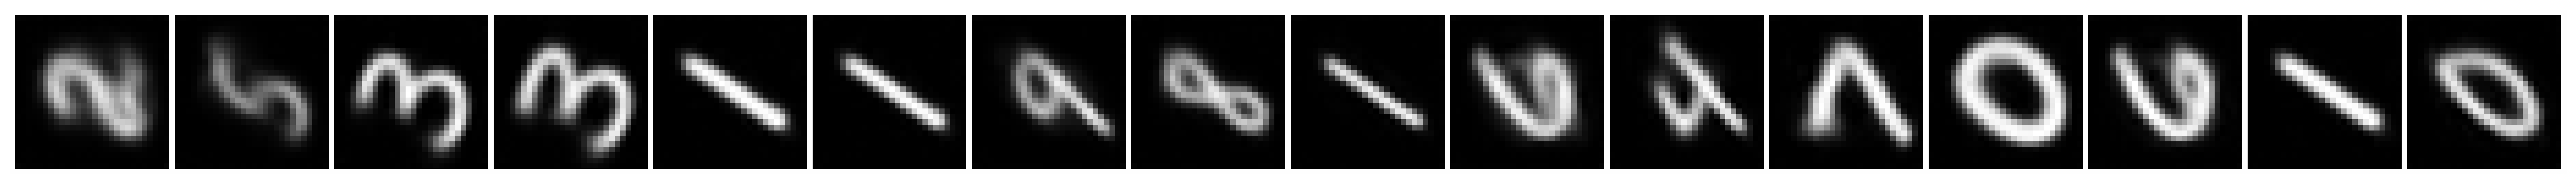

Step 11500: loss= 776.557


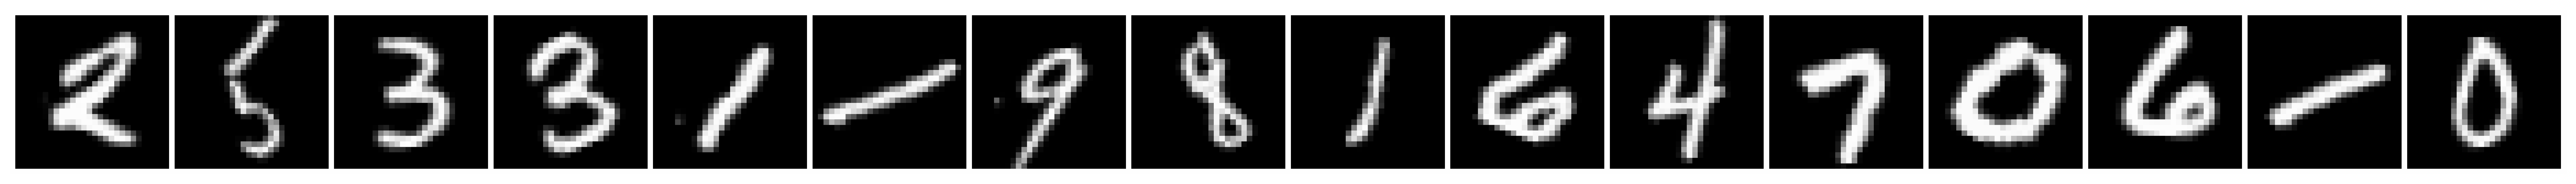

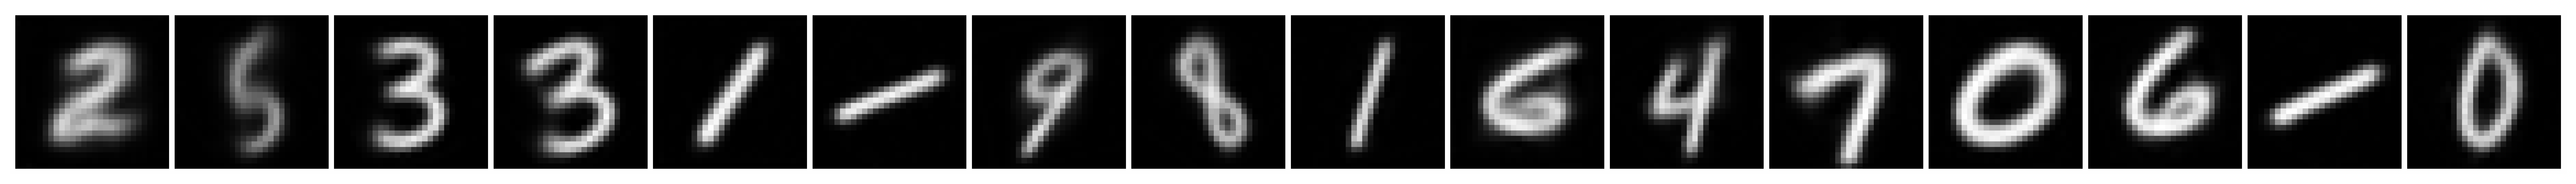

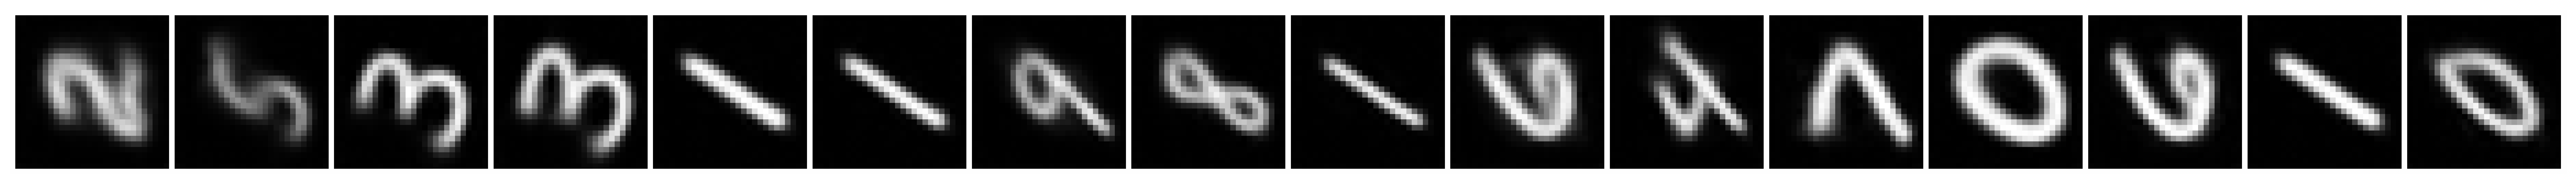

Step 12000: loss= 769.567


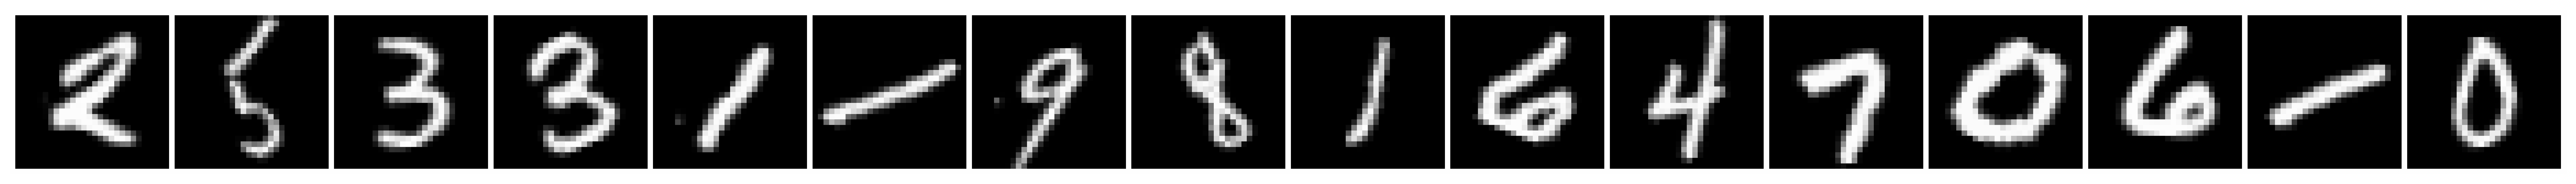

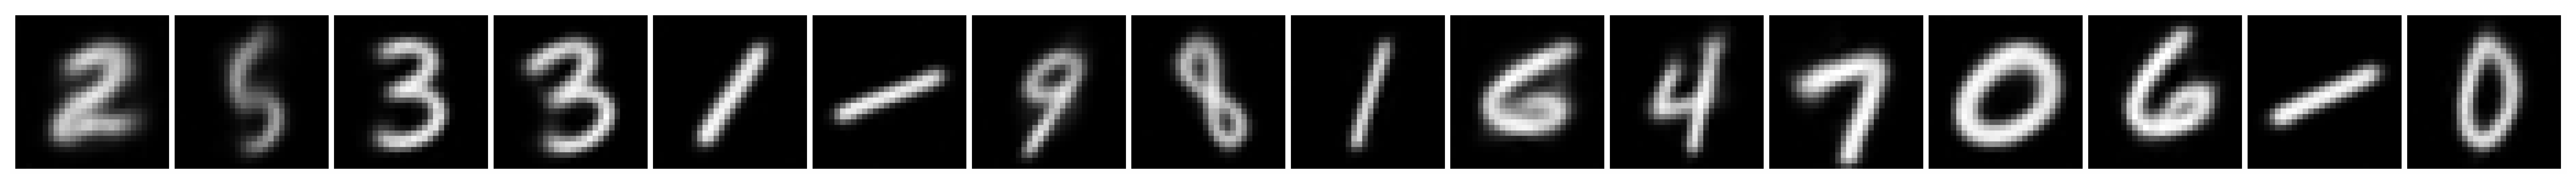

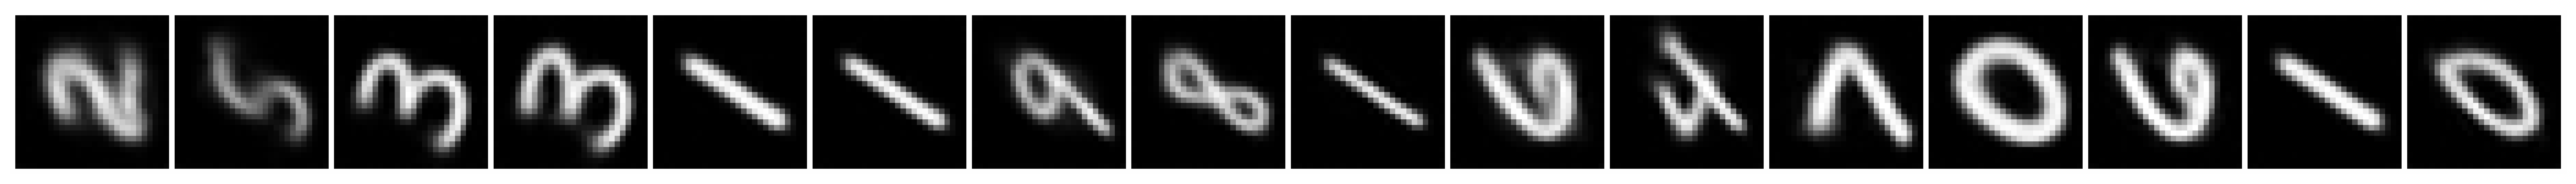

Step 12500: loss= 770.318


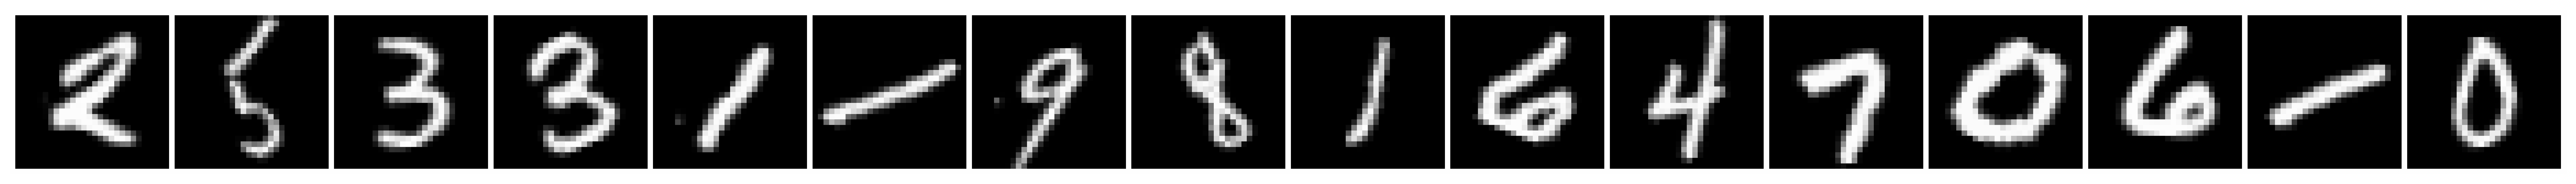

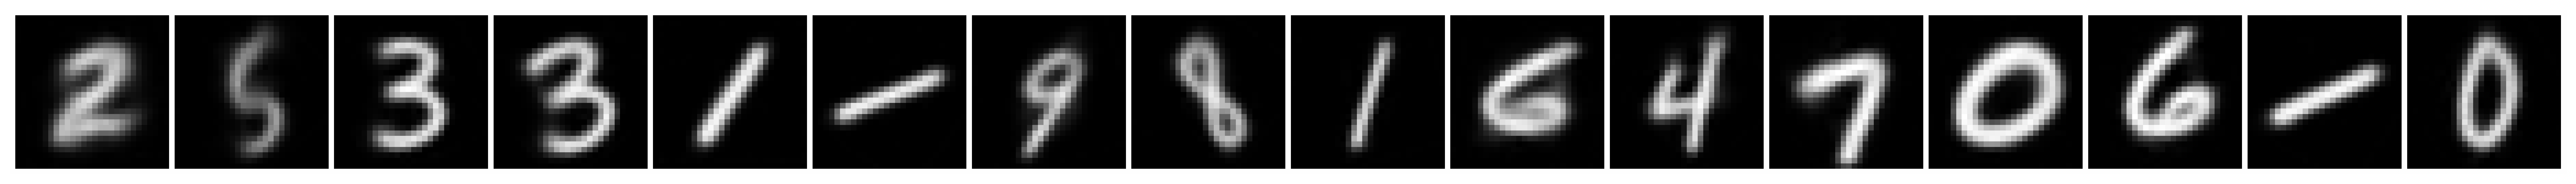

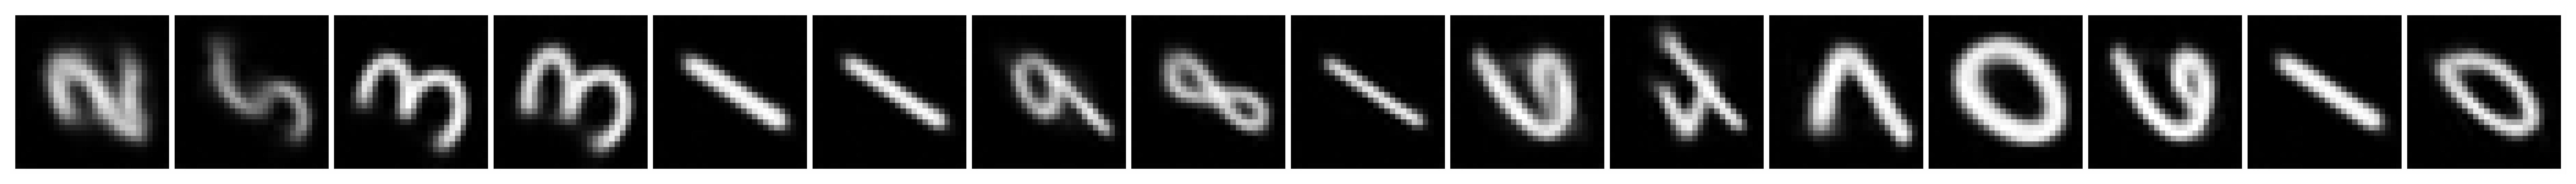

Step 13000: loss= 768.090


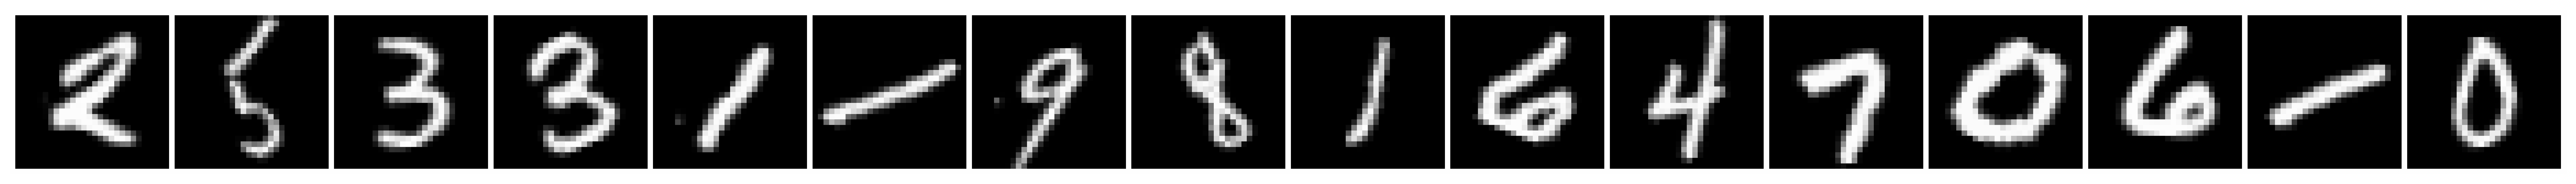

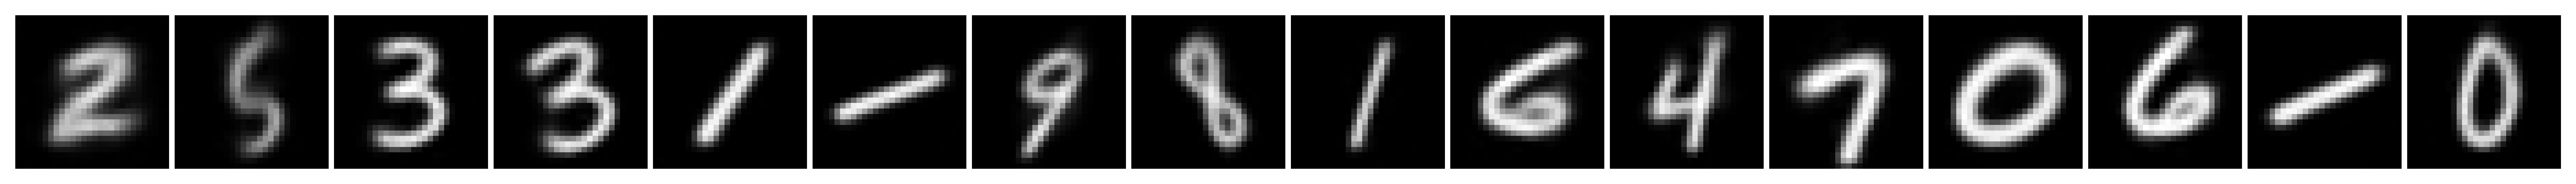

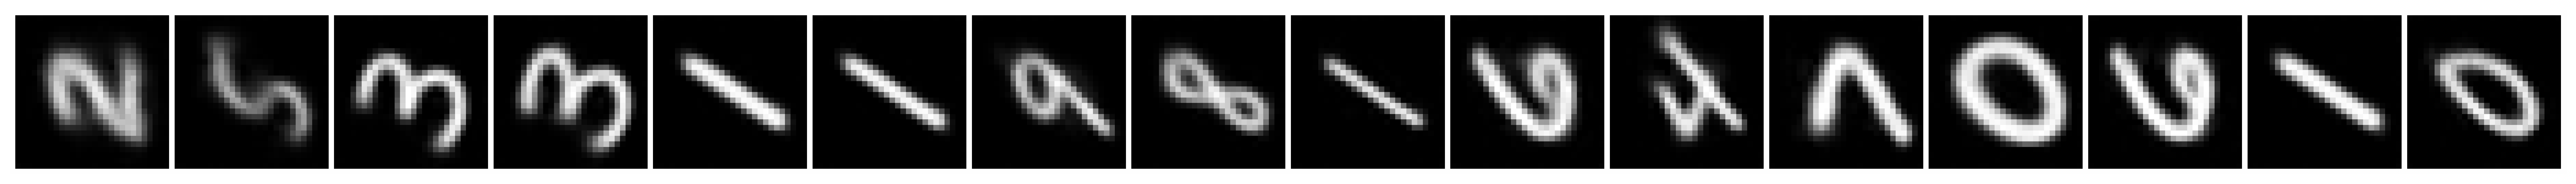

Step 13500: loss= 761.372


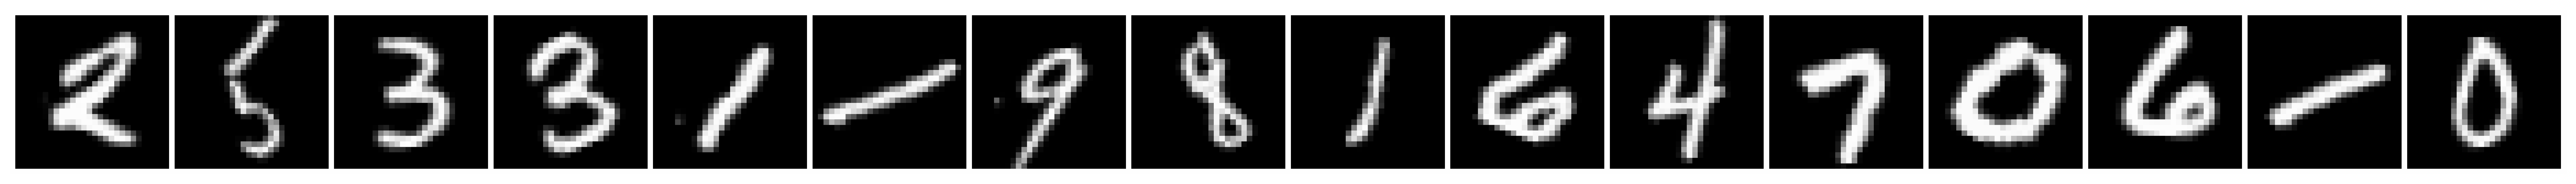

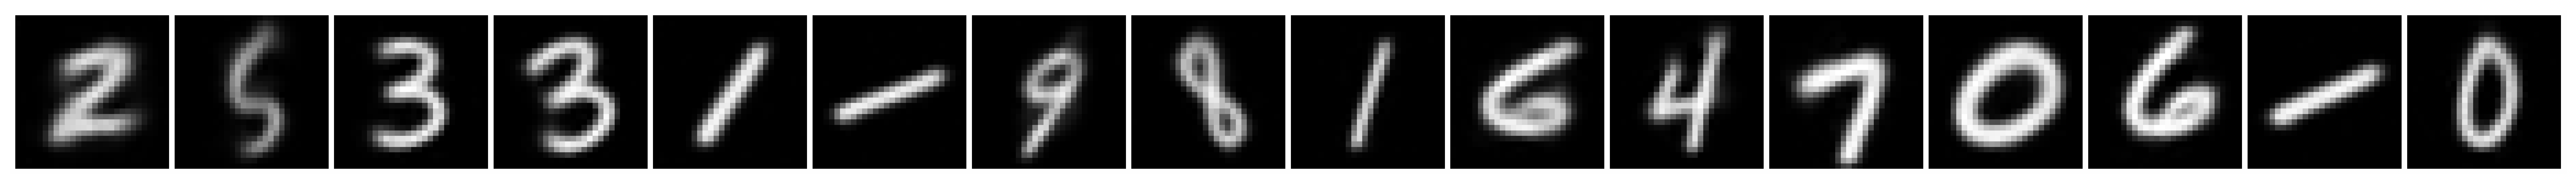

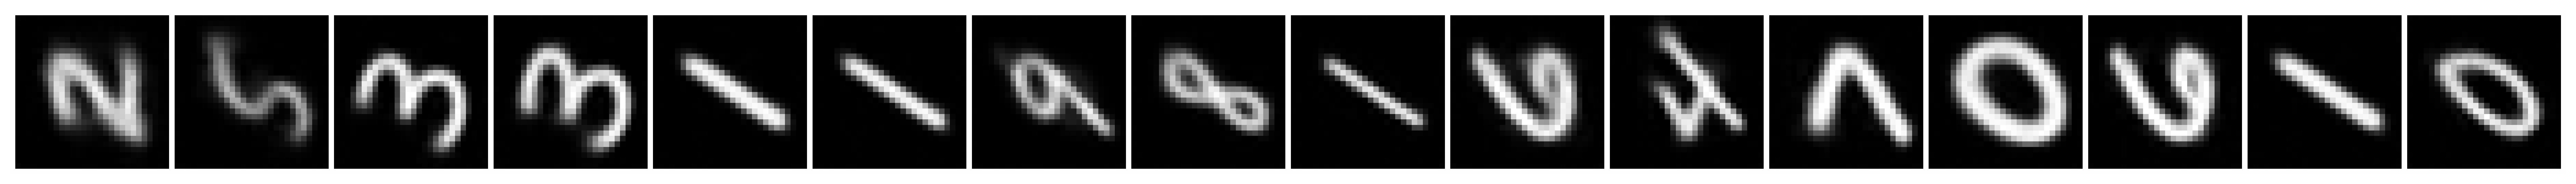

Step 14000: loss= 764.415


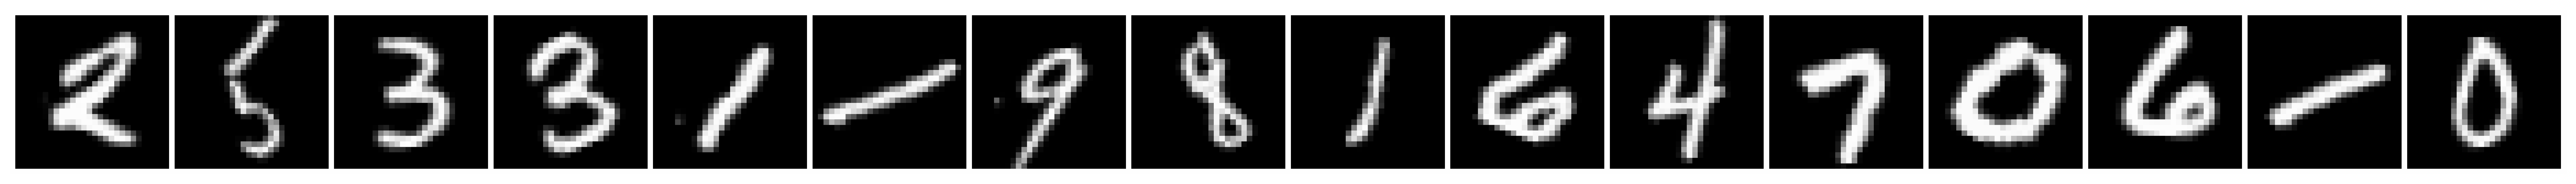

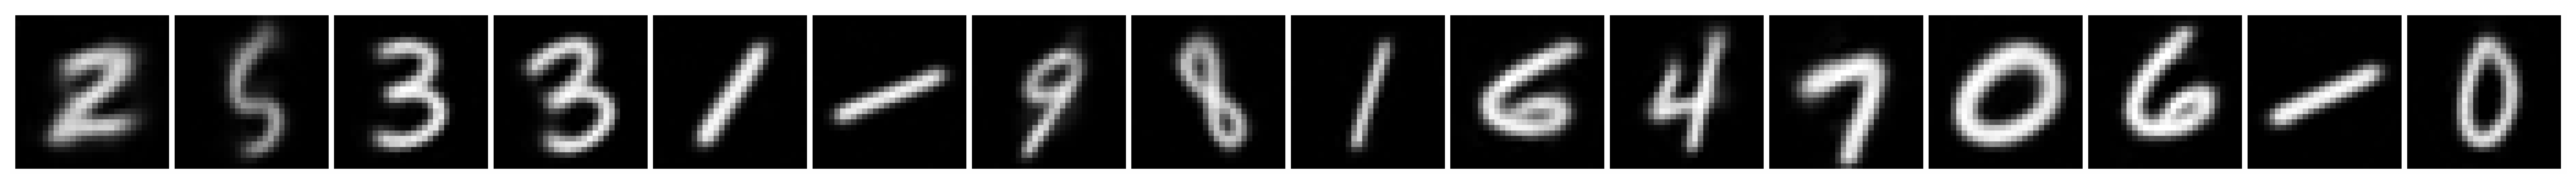

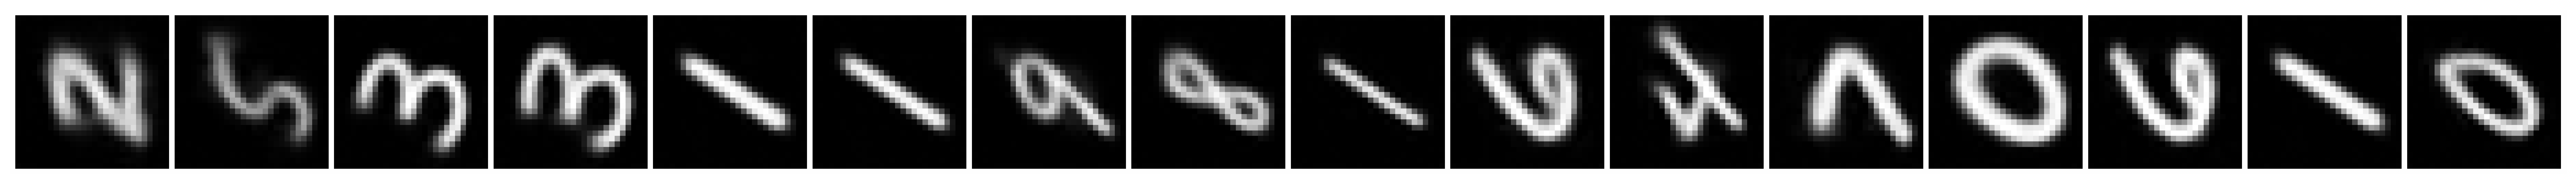

Step 14500: loss= 763.868


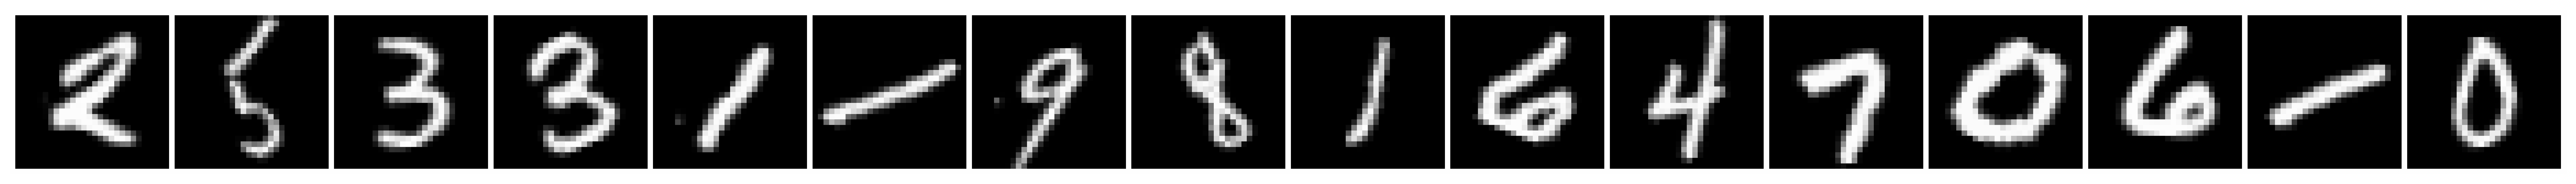

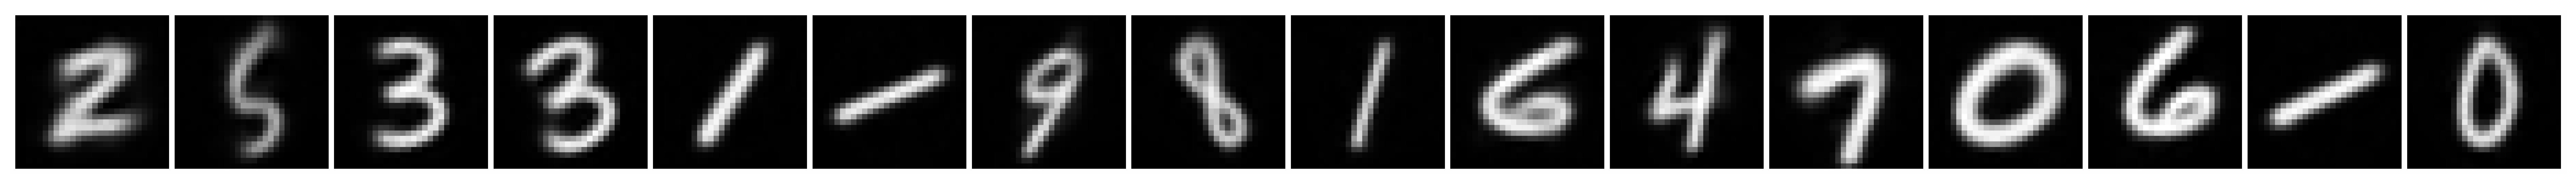

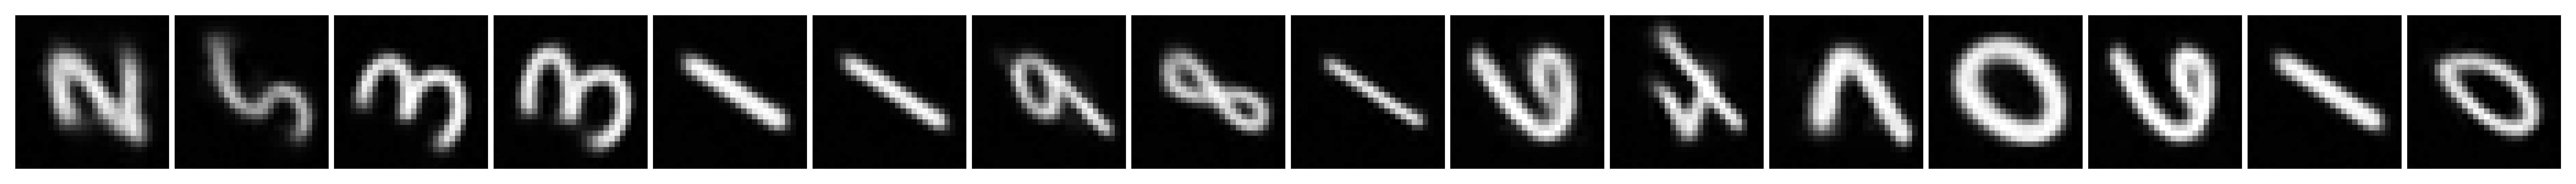

Step 15000: loss= 763.269


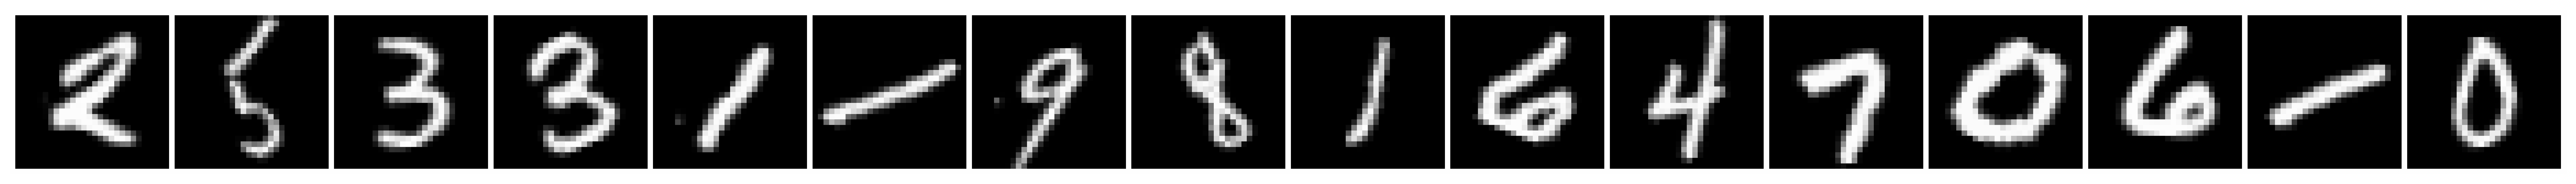

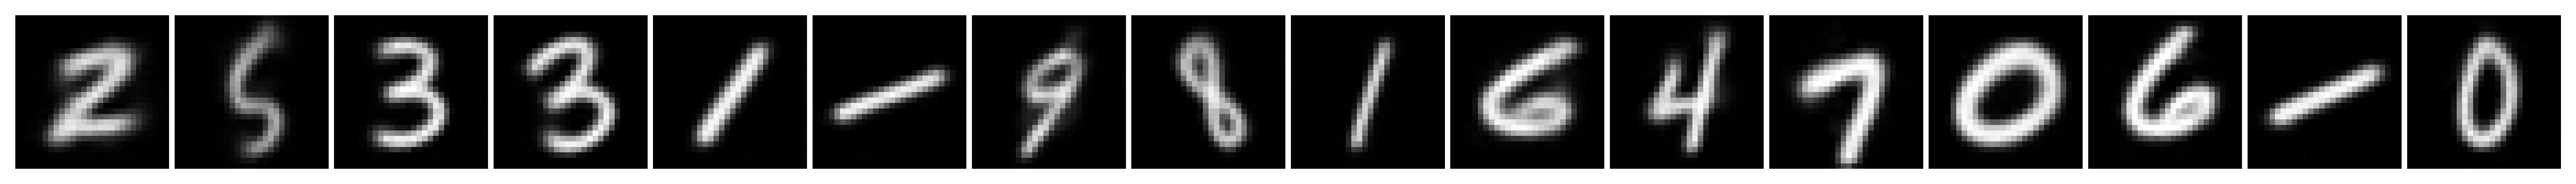

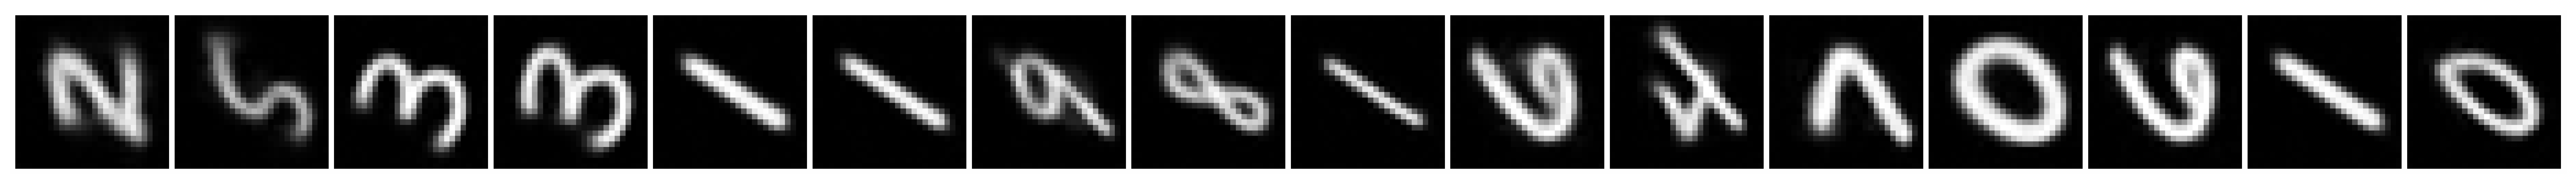

In [13]:
sampling_rng = random.PRNGKey(0)

for step in tqdm(range(STEPS)):
    x_batch = next(train_ds)['image']
    train_step_rng, rng = random.split(rng)
    state, (loss, metrics) = train_step(state, x_batch, rng)

    if step % 500 == 0:
        print(f"Step {step:5}: loss={loss:8.3f}")

        x_batch = plot_data['image']
        # print("Original images")
        orig_fig = plot_img_array(x_batch, ncol=PLOT_NUM_EXAMPLES, pad_value=1, padding=1)
        def reconstruct(x, prototype=False, sample_z=False, 
                        sample_xhat=False, sample_θ=False):
            rng = random.fold_in(sampling_rng, lax.axis_index('batch'))
            return model.apply({'params': state.params}, x, rng,
                               prototype=prototype, sample_z=sample_z,
                               sample_xhat=sample_xhat, sample_θ=sample_θ,
                               method=model.reconstruct)

        x_recon_modes = jax.vmap(
            reconstruct, axis_name='batch', in_axes=(0, None, None, None, None)
        )(x_batch, False, False, False, True)
        # print("Reconstructions")
        recon_fig = plot_img_array(x_recon_modes, ncol=PLOT_NUM_EXAMPLES, pad_value=1, padding=1)

        x_recon_proto_modes = jax.vmap(
            reconstruct, axis_name='batch', in_axes=(0, None, None, None, None)
        )(x_batch, True, False, False, True)
        # print("Prototypes")
        proto_fig = plot_img_array(x_recon_proto_modes, ncol=PLOT_NUM_EXAMPLES, pad_value=1, padding=1)

In [14]:
orig_fig.savefig(f"results/orig_{LOW_ANGLE}_{HIGH_ANGLE}_{seed}.pdf", bbox_inches='tight', pad_inches=0, dpi=400)
recon_fig.savefig(f"results/recon_{LOW_ANGLE}_{HIGH_ANGLE}_{seed}.pdf", bbox_inches='tight', pad_inches=0, dpi=400)
proto_fig.savefig(f"results/proto_{LOW_ANGLE}_{HIGH_ANGLE}_{seed}.pdf", bbox_inches='tight', pad_inches=0, dpi=400)

In [15]:
CKPT_DIR = f'results/ckpts/ckpt_{LOW_ANGLE}_{HIGH_ANGLE}_{seed}'
checkpoints.save_checkpoint(ckpt_dir=CKPT_DIR, target=state, step=step)

'results/ckpts/ckpt_-45_45/checkpoint_15000'

### Eval

In [16]:
val_pp_fn = make_pp_with_rng(pp_train)

val_ds = tfds.load('MNIST', split='train[:10000]')
val_ds = val_ds.shuffle(10_000, seed=shuffle_rng[0])
val_ds = val_ds.enumerate().map(val_pp_fn, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE_VAL)
val_ds = val_ds.as_numpy_iterator()

In [19]:
@jax.jit
def angle_and_elbo(x, batch_rng):
    rng = random.fold_in(batch_rng, lax.axis_index('batch'))
    q_z_x, q_θ_x, p_x_xhat_θ, _, p_θ_z, p_z = model.apply(
        {'params': state.params}, x, rng,
    )

    θ = q_θ_x.sample(sample_shape=(10,), seed=rng).mean()
    elbo, _ = calculate_livae_elbo(x, q_z_x, q_θ_x, p_x_xhat_θ, p_z, p_θ_z, state.β)

    return θ, elbo

In [20]:
eval_key = random.PRNGKey(0)
θs = []
elbos = []
for val_batch in val_ds:
    batch_θ, batch_elbo = jax.vmap(angle_and_elbo, axis_name='batch', in_axes=(0, None))(val_batch['image'], eval_key)
    θs.append(batch_θ)
    elbos.append(batch_elbo)
θs = jnp.concatenate(θs, axis=0)
θs = jnp.degrees(θs)

elbo = jnp.concatenate(elbos, axis=0).mean(axis=0)
print(elbo)

-763.32086


In [21]:
jnp.save(f"results/angles_{LOW_ANGLE}_{HIGH_ANGLE}_{seed}.npy", θs)